In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'smartphone-decimeter-2022:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F35779%2F3604062%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T233158Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D64576778726b0c8b5513d2078e81974bbee1d679003960312f0d3090eb5da8fe80358f3c7fb6e6d724b6f37606fe9916adfa26325450cf4ed2f9a093addc832a8c829d6199ff1328dd9c477b5abda1bd895c4d4506ec80451bc01efeea6b5f2e5768997aa5b18c19d661967c9ce18898dfac7c7dbfde5cfcf8809c80e78a56ee69f69abaf581020900fe833d58a6c179951abaad2f0317476228e8dfae1bf2d90bde9bbab377831aa7bf98a90afc5cca591045fb78b377ed3c0156c215e3e15035136ff806447c292099f486cff0f58ac4f63d959dbfbaffe759a2a7d8b03c4b4c28b1f7ea70256eced0a915bd747cc362c10b92ebfdae450ff431d77242f3e7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5270329079 bytes downloaded
Downloaded and uncompressed: smartphone-decimeter-2022
Data source import complete.


In [5]:
!pip install lightgbm


**Import**

In [7]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 41.0 MB/s eta 0:00:00


In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
!pip install folium
!pip install simdkalman
import pickle
import sys
import warnings
from glob import glob
import requests
import folium
from shapely.geometry import Point, shape
import shapely.wkt
from geopandas import GeoDataFrame
import simdkalman
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm
pd.options.mode.use_inf_as_na = True

<ipython-input-8-d96e97a965a9>:29: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


In [9]:
for dirname, _,filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

/kaggle/input/smartphone-decimeter-2022/sample_submission.csv
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel6Pro/device_gnss.csv
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel6Pro/ground_truth.csv
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel6Pro/device_imu.csv
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel6Pro/supplemental/span_log.nmea
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel6Pro/supplemental/gnss_rinex.21o
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel6Pro/supplemental/gnss_log.txt
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel5/device_gnss.csv
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel5/ground_truth.csv
/kaggle/input/smartphone-decimeter-2022/train/2021-12-28-US-MTV-1/GooglePixel5/device_imu.csv
/kaggle/input/smartphone-decimet

In [10]:
import os
os.listdir('/kaggle/input/')

['smartphone-decimeter-2022']

In [11]:
data=pd.read_csv('../input/smartphone-decimeter-2022/sample_submission.csv')

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
data.head()

tripId  UnixTimeMillis  LatitudeDegrees  \
0  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650832999        37.904611   
1  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650833999        37.904611   
2  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650834999        37.904611   
3  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650835999        37.904611   
4  2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650836999        37.904611   

   LongitudeDegrees  
0        -86.481078  
1        -86.481078  
2        -86.481078  
3        -86.481078  
4        -86.481078

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66097 entries, 0 to 66096
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tripId            66097 non-null  object 
 1   UnixTimeMillis    66097 non-null  int64  
 2   LatitudeDegrees   66097 non-null  float64
 3   LongitudeDegrees  66097 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.0+ MB


In [15]:
data['tripId'].value_counts()

tripId
2022-02-24-US-LAX-5/SamsungGalaxyS20Ultra    4514
2022-02-24-US-LAX-1/SamsungGalaxyS20Ultra    3581
2021-08-24-US-SVL-2/GooglePixel5             3314
2022-02-23-US-LAX-3/XiaomiMi8                2880
2022-02-23-US-LAX-1/GooglePixel5             2845
2021-09-28-US-MTV-1/GooglePixel5             2485
2022-02-24-US-LAX-3/XiaomiMi8                2464
2022-02-23-US-LAX-5/XiaomiMi8                2420
2022-03-22-US-MTV-1/SamsungGalaxyS20Ultra    2109
2022-04-25-US-OAK-1/GooglePixel5             1912
2022-03-31-US-LAX-3/SamsungGalaxyS20Ultra    1820
2021-09-07-US-MTV-1/SamsungGalaxyS20Ultra    1802
2021-09-20-US-MTV-1/XiaomiMi8                1795
2021-09-20-US-MTV-2/GooglePixel4             1742
2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra    1724
2022-01-26-US-MTV-1/XiaomiMi8                1698
2021-08-17-US-MTV-1/GooglePixel5             1673
2022-04-01-US-LAX-1/SamsungGalaxyS20Ultra    1670
2022-02-08-US-SJC-1/XiaomiMi8                1665
2022-03-14-US-MTV-1/GooglePixel5             1635
2022-04-25-US-OAK-2/GooglePixel4             1584
2021-11-30-US-MTV-1/GooglePixel5             1521
2022-04-01-US-LAX-3/XiaomiMi8                1462
2021-11-05-US-MTV-1/XiaomiMi8                1442
2022-04-22-US-OAK-1/GooglePixel5             1432
2021-06-22-US-MTV-1/XiaomiMi8                1398
2022-04-22-US-OAK-2/XiaomiMi8                1394
2022-02-15-US-SJC-1/GooglePixel5             1392
2022-03-31-US-LAX-1/GooglePixel5             1301
2021-09-14-US-MTV-1/GooglePixel5             1270
2021-08-12-US-MTV-1/GooglePixel4             1265
2022-03-17-US-SJC-1/GooglePixel5             1172
2022-01-18-US-SJC-2/GooglePixel5              942
2022-01-11-US-MTV-1/GooglePixel6Pro           942
2022-01-04-US-MTV-1/SamsungGalaxyS20Ultra     922
2022-02-01-US-SJC-1/XiaomiMi8                 910
Name: count, dtype: int64

In [16]:
X=data[['UnixTimeMillis','LatitudeDegrees','LongitudeDegrees']]
y=data['tripId']

In [17]:
data=pd.DataFrame(data)
print(data)

                                          tripId  UnixTimeMillis  \
0      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650832999   
1      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650833999   
2      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650834999   
3      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650835999   
4      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650836999   
...                                          ...             ...   
66092           2022-04-25-US-OAK-2/GooglePixel4   1650927742650   
66093           2022-04-25-US-OAK-2/GooglePixel4   1650927743642   
66094           2022-04-25-US-OAK-2/GooglePixel4   1650927744651   
66095           2022-04-25-US-OAK-2/GooglePixel4   1650927745640   
66096           2022-04-25-US-OAK-2/GooglePixel4   1650927746632   

       LatitudeDegrees  LongitudeDegrees  
0            37.904611        -86.481078  
1            37.904611        -86.481078  
2            37.904611        -86.481078  
3          

In [18]:
 X=data.iloc[:,[2,3]].values
print(X)

[[ 37.90461132 -86.48107806]
 [ 37.90461132 -86.48107806]
 [ 37.90461132 -86.48107806]
 ...
 [ 37.90461132 -86.48107806]
 [ 37.90461132 -86.48107806]
 [ 37.90461132 -86.48107806]]


In [19]:
y=data.iloc[:,0:4].values
print(y)

[['2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra' 1619650832999
  37.9046113156345 -86.48107806249548]
 ['2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra' 1619650833999
  37.9046113156345 -86.48107806249548]
 ['2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra' 1619650834999
  37.9046113156345 -86.48107806249548]
 ...
 ['2022-04-25-US-OAK-2/GooglePixel4' 1650927744651 37.9046113156345
  -86.48107806249548]
 ['2022-04-25-US-OAK-2/GooglePixel4' 1650927745640 37.9046113156345
  -86.48107806249548]
 ['2022-04-25-US-OAK-2/GooglePixel4' 1650927746632 37.9046113156345
  -86.48107806249548]]


In [20]:
cname_ = glob('../input/smartphone-decimeter-2022/train/*')
tmp = []
for i in cname_:
    tmp.extend(glob(f'{i}/*'))

cname=[]

for r in tmp:
    cname.append([r.split('/')[4],r.split('/')[5]])

cname = pd.DataFrame(sorted(cname))
cname

0                      1
0    2020-05-15-US-MTV-1         GooglePixel4XL
1    2020-05-21-US-MTV-1           GooglePixel4
2    2020-05-21-US-MTV-1         GooglePixel4XL
3    2020-05-21-US-MTV-2           GooglePixel4
4    2020-05-21-US-MTV-2         GooglePixel4XL
..                   ...                    ...
165  2021-12-15-US-MTV-1              XiaomiMi8
166  2021-12-28-US-MTV-1           GooglePixel5
167  2021-12-28-US-MTV-1        GooglePixel6Pro
168  2021-12-28-US-MTV-1  SamsungGalaxyS20Ultra
169  2021-12-28-US-MTV-1              XiaomiMi8

[170 rows x 2 columns]

List of mobile phones used in train

In [21]:
cname[1].value_counts()

1
GooglePixel4             43
GooglePixel4XL           39
XiaomiMi8                29
GooglePixel5             28
SamsungGalaxyS20Ultra    23
GooglePixel6Pro           8
Name: count, dtype: int64

List of mobile phones used in test

In [22]:
cname_ = glob('../input/smartphone-decimeter-2022/test/*')
tmp = []
for i in cname_:
    tmp.extend(glob(f'{i}/*'))

cname=[]

for r in tmp:
    cname.append([r.split('/')[4],r.split('/')[5]])

cname = pd.DataFrame(sorted(cname))
cname[1].value_counts()

1
GooglePixel5             13
XiaomiMi8                11
SamsungGalaxyS20Ultra     8
GooglePixel4              3
GooglePixel6Pro           1
Name: count, dtype: int64

Since the train data is from 2020 and the test is from 2021-2022, it seems that the mobile phone used is a little different.

Read the metadata file

In [23]:
import json
raw = open('../input/smartphone-decimeter-2022/metadata/raw_state_bit_map.json', 'r')
json.load(raw)

{'0': 'Code Lock',
 '1': 'Bit Sync',
 '2': 'Subframe Sync',
 '3': 'Time Of Week Decoded State',
 '4': 'Millisecond Ambiguity',
 '5': 'Symbol Sync',
 '6': 'GLONASS String Sync',
 '7': 'GLONASS Time Of Day Decoded',
 '8': 'BEIDOU D2 Bit Sync',
 '9': 'BEIDOU D2 Subframe Sync',
 '10': 'Galileo E1BC Code Lock',
 '11': 'Galileo E1C 2^nd^ Code Lock',
 '12': 'Galileo E1B Page Sync',
 '13': 'SBAS Sync',
 '14': 'Time Of Week Known',
 '15': 'GLONASS Time Of Day Known'}

In [24]:
import json
bit = open('../input/smartphone-decimeter-2022/metadata/accumulated_delta_range_state_bit_map.json', 'r')
json.load(bit)

{'0': 'VALID',
 '1': 'RESET',
 '2': 'CYCLE_SLIP',
 '3': 'HALF_CYCLE_RESOLVED',
 '4': 'HALF_CYCLE_REPORTED'}

In [25]:
mapping = pd.read_csv('../input/smartphone-decimeter-2022/metadata/constellation_type_mapping.csv')
mapping

constellationType constellationName
0                  0           UNKNOWN
1                  1               GPS
2                  2              SBAS
3                  3           GLONASS
4                  4              QZSS
5                  5            BEIDOU
6                  6           GALILEO
7                  7             IRNSS

Read the sample file(2020-05-15-US-MTV-1)

In [26]:
ground = pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/ground_truth.csv')
ground

MessageType Provider  LatitudeDegrees  LongitudeDegrees  AltitudeMeters  \
0            Fix       GT        37.416619       -122.082065             NaN   
1            Fix       GT        37.416619       -122.082065             NaN   
2            Fix       GT        37.416619       -122.082065             NaN   
3            Fix       GT        37.416619       -122.082065             NaN   
4            Fix       GT        37.416619       -122.082065             NaN   
...          ...      ...              ...               ...             ...   
3357         Fix       GT        37.631664       -122.424975             NaN   
3358         Fix       GT        37.631667       -122.424971             NaN   
3359         Fix       GT        37.631667       -122.424972             NaN   
3360         Fix       GT        37.631667       -122.424972             NaN   
3361         Fix       GT        37.631667       -122.424972             NaN   

      SpeedMps  AccuracyMeters  BearingDegrees  UnixTimeMillis  
0     0.002044             0.1       92.968750   1589573679445  
1     0.002198             0.1       92.969666   1589573680445  
2     0.001414             0.1       92.969850   1589573681445  
3     0.001414             0.1       92.969850   1589573682445  
4     0.001414             0.1       92.969910   1589573683445  
...        ...             ...             ...             ...  
3357  0.797332             0.1       53.082825   1589577036445  
3358  0.056422             0.1       53.170044   1589577037445  
3359  0.006325             0.1       53.168518   1589577038445  
3360  0.005113             0.1       53.166443   1589577039445  
3361  0.002995             0.1       53.167360   1589577040445  

[3362 rows x 9 columns]

MessageType - "Fix", the prefix of sentence.

Provider - "GT", short for ground truth.


[Latitude/Longitude]Degrees - The WGS84 latitude, longitude (in decimal degrees) estimated by the reference GNSS receiver (NovAtel SPAN). When extracting from the NMEA file, linear interpolation has been applied to align the location to the expected non-integer timestamps.


AltitudeMeters - The height above the WGS84 ellipsoid (in meters) estimated by the reference GNSS receiver.

SpeedMps* - The speed over ground in meters per second.


AccuracyMeters - The estimated horizontal accuracy radius in meters of this location at the 68th percentile confidence level. This means that there is a 68% chance that the true location of the device is within a distance of this uncertainty of the reported location.


BearingDegrees - Bearing is measured in degrees clockwise from north. It ranges from 0 to 359.999 degrees.


UnixTimeMillis - An integer number of milliseconds since the GPS epoch (1970/1/1 midnight UTC). Converted from GnssClock.

In [27]:
imu= pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/device_imu.csv')
imu

MessageType  utcTimeMillis  MeasurementX  MeasurementY  MeasurementZ  \
0       UncalAccel  1589573679447      0.237913      9.250001      1.784782   
1        UncalGyro  1589573679450     -0.022198      0.004974      0.014298   
2         UncalMag  1589573679450      2.812906    -37.320263     -1.189655   
3       UncalAccel  1589573679457      0.134411      9.673122      1.313673   
4         UncalMag  1589573679460      2.601327    -37.849490     -0.733490   
...            ...            ...           ...           ...           ...   
734851  UncalAccel  1589577041402      0.393715      9.786283      0.759665   
734852    UncalMag  1589577041407      6.118653    -41.951572    -16.720966   
734853  UncalAccel  1589577041412      0.113705      9.996571      1.240902   
734854    UncalMag  1589577041417      6.266749    -41.931866    -16.268131   
734855   UncalGyro  1589577041422      0.005176     -0.001123     -0.036102   

           BiasX      BiasY     BiasZ  
0        0.00000   0.000000   0.00000  
1        0.00000   0.000000   0.00000  
2       74.85504 -10.046193 -44.48028  
3        0.00000   0.000000   0.00000  
4       74.85504 -10.046193 -44.48028  
...          ...        ...       ...  
734851   0.00000   0.000000   0.00000  
734852  74.85504 -10.046193 -44.48028  
734853   0.00000   0.000000   0.00000  
734854  74.85504 -10.046193 -44.48028  
734855   0.00000   0.000000   0.00000  

[734856 rows x 8 columns]

In [28]:
gnss = pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/device_gnss.csv')
gnss

MessageType  utcTimeMillis       TimeNanos  LeapSecond  \
0             Raw  1589573679445   9825908000000         NaN   
1             Raw  1589573679445   9825908000000         NaN   
2             Raw  1589573679445   9825908000000         NaN   
3             Raw  1589573679445   9825908000000         NaN   
4             Raw  1589573679445   9825908000000         NaN   
...           ...            ...             ...         ...   
90148         Raw  1589577040445  13186908000000         NaN   
90149         Raw  1589577040445  13186908000000         NaN   
90150         Raw  1589577040445  13186908000000         NaN   
90151         Raw  1589577040445  13186908000000         NaN   
90152         Raw  1589577040445  13186908000000         NaN   

             FullBiasNanos  BiasNanos  BiasUncertaintyNanos  \
0     -1273599071537525599   0.414394             29.760322   
1     -1273599071537525599   0.414394             29.760322   
2     -1273599071537525599   0.414394             29.760322   
3     -1273599071537525599   0.414394             29.760322   
4     -1273599071537525599   0.414394             29.760322   
...                    ...        ...                   ...   
90148 -1273599071537517829   0.863317             18.450928   
90149 -1273599071537517829   0.863317             18.450928   
90150 -1273599071537517829   0.863317             18.450928   
90151 -1273599071537517829   0.863317             18.450928   
90152 -1273599071537517829   0.863317             18.450928   

       DriftNanosPerSecond  DriftUncertaintyNanosPerSecond  \
0                 0.058358                       10.712862   
1                 0.058358                       10.712862   
2                 0.058358                       10.712862   
3                 0.058358                       10.712862   
4                 0.058358                       10.712862   
...                    ...                             ...   
90148             6.537852                        9.715101   
90149             6.537852                        9.715101   
90150             6.537852                        9.715101   
90151             6.537852                        9.715101   
90152             6.537852                        9.715101   

       HardwareClockDiscontinuityCount  ...  SvVelocityYEcefMetersPerSecond  \
0                                    6  ...                      -17.054923   
1                                    6  ...                     1097.133346   
2                                    6  ...                    -2177.983493   
3                                    6  ...                      222.719634   
4                                    6  ...                      293.424387   
...                                ...  ...                             ...   
90148                                7  ...                    -2560.769345   
90149                                7  ...                    -1332.986509   
90150                                7  ...                     -228.160204   
90151                                7  ...                    -2406.056160   
90152                                7  ...                     1237.500857   

       SvVelocityZEcefMetersPerSecond  SvClockBiasMeters  \
0                         3156.993021      -1.368346e+05   
1                         2801.579397      -8.157525e+04   
2                         1370.434597       3.524512e+04   
3                         -841.694753       7.952710e+04   
4                          302.063410      -4.746933e+04   
...                               ...                ...   
90148                     1124.324963       1.300448e+03   
90149                    -2573.160692       4.004744e+04   
90150                     2948.268971       2.599032e+05   
90151                     -687.027713       1.170587e+06   
90152                      865.977576       1.678042e+05   

       SvClockDriftMetersPerSecond   IsrbMeters  IonosphericDelay

mapping the Ground True data on the map.

In [29]:
from folium import plugins
df_locs = list(ground[['LatitudeDegrees','LongitudeDegrees']].values)
fol_map = folium.Map([ground['LatitudeDegrees'].median(), ground['LongitudeDegrees'].median()],zoom_start=11)
heat_map = plugins.HeatMap(df_locs)
fol_map.add_child(heat_map)
markers = plugins.MarkerCluster(locations = df_locs)
fol_map.add_child(markers)

Read the supplemental

gnss_log.txt

In [30]:
f = open('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_log.txt', 'r')
log = f.read()
f.close()
log[:500]

'# \n# Header Description:\n# \n# Version: v3.0.0.16 Platform: null Manufacturer: Google Model: Pixel 4 XL\n# \n# Raw,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,Svid,TimeOffsetNanos,State,ReceivedSvTimeNanos,ReceivedSvTimeUncertaintyNanos,Cn0DbHz,PseudorangeRateMetersPerSecond,PseudorangeRateUncertaintyMetersPerSecond,AccumulatedDeltaRangeState,AccumulatedDeltaRa'

Txt to Pandas

In [31]:
    path ='../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_log.txt'
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
      if dataline !='' and dataline[0] !='':
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            if dataline !='' and dataline[0] !='':
                datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

In [32]:
results['Raw']

utcTimeMillis       TimeNanos  LeapSecond  TimeUncertaintyNanos  \
0      1589573679445   9825908000000         NaN                   NaN   
1      1589573679445   9825908000000         NaN                   NaN   
2      1589573679445   9825908000000         NaN                   NaN   
3      1589573679445   9825908000000         NaN                   NaN   
4      1589573679445   9825908000000         NaN                   NaN   
...              ...             ...         ...                   ...   
90148  1589577040445  13186908000000         NaN                   NaN   
90149  1589577040445  13186908000000         NaN                   NaN   
90150  1589577040445  13186908000000         NaN                   NaN   
90151  1589577040445  13186908000000         NaN                   NaN   
90152  1589577040445  13186908000000         NaN                   NaN   

             FullBiasNanos  BiasNanos  BiasUncertaintyNanos  \
0     -1273599071537525599   0.414394             29.760322   
1     -1273599071537525599   0.414394             29.760322   
2     -1273599071537525599   0.414394             29.760322   
3     -1273599071537525599   0.414394             29.760322   
4     -1273599071537525599   0.414394             29.760322   
...                    ...        ...                   ...   
90148 -1273599071537517829   0.863317             18.450928   
90149 -1273599071537517829   0.863317             18.450928   
90150 -1273599071537517829   0.863317             18.450928   
90151 -1273599071537517829   0.863317             18.450928   
90152 -1273599071537517829   0.863317             18.450928   

       DriftNanosPerSecond  DriftUncertaintyNanosPerSecond  \
0                 0.058358                       10.712862   
1                 0.058358                       10.712862   
2                 0.058358                       10.712862   
3                 0.058358                       10.712862   
4                 0.058358                       10.712862   
...                    ...                             ...   
90148             6.537852                        9.715101   
90149             6.537852                        9.715101   
90150             6.537852                        9.715101   
90151             6.537852                        9.715101   
90152             6.537852                        9.715101   

       HardwareClockDiscontinuityCount  ...  SnrInDb  ConstellationType  \
0                                    6  ...      NaN                  1   
1                                    6  ...      NaN                  1   
2                                    6  ...      NaN                  1   
3                                    6  ...      NaN                  1   
4                                    6  ...      NaN                  1   
...                                ...  ...      ...                ...   
90148                                7  ...      NaN                  1   
90149                                7  ...      NaN                  6   
90150                                7  ...      NaN                  6   
90151                                7  ...      NaN                  6   
90152                                7  ...      NaN                  6   

       AgcDb  BasebandCn0DbHz  FullInterSignalBiasNanos  \
0        NaN              NaN                       NaN   
1        NaN              NaN                       NaN   
2        NaN              NaN                       NaN   
3        NaN              NaN                       NaN   
4        NaN              NaN                       NaN   
...      ...              ...                       ...   
90148    NaN              NaN                       NaN   
90149    NaN              NaN                       NaN   
90150    NaN              NaN                       NaN   
90151    NaN              NaN                       NaN   
90152    NaN              NaN                       NaN   

      

In [33]:
results['UncalAccel']

utcTimeMillis  elapsedRealtimeNanos  UncalAccelXMps2  UncalAccelYMps2  \
0       1589573679447                   NaN         0.237913         9.250001   
1       1589573679457                   NaN         0.134411         9.673122   
2       1589573679467                   NaN        -0.085421        10.311209   
3       1589573679477                   NaN        -0.091420         9.795237   
4       1589573679486                   NaN        -0.106993         9.221649   
...               ...                   ...              ...              ...   
226347  1589577041373                   NaN         0.389894         9.521341   
226348  1589577041383                   NaN         0.550553         9.661240   
226349  1589577041393                   NaN         0.528499         9.866081   
226350  1589577041402                   NaN         0.393715         9.786283   
226351  1589577041412                   NaN         0.113705         9.996571   

        UncalAccelZMps2  BiasXMps2  BiasYMps2  BiasZMps2  
0              1.784782        0.0        0.0        0.0  
1              1.313673        0.0        0.0        0.0  
2              0.171189        0.0        0.0        0.0  
3              0.594629        0.0        0.0        0.0  
4              1.844052        0.0        0.0        0.0  
...                 ...        ...        ...        ...  
226347         1.182911        0.0        0.0        0.0  
226348         1.435501        0.0        0.0        0.0  
226349         0.680037        0.0        0.0        0.0  
226350         0.759665        0.0        0.0        0.0  
226351         1.240902        0.0        0.0        0.0  

[226352 rows x 8 columns]

In [34]:
results['UncalGyro']

utcTimeMillis  elapsedRealtimeNanos  UncalGyroXRadPerSec  \
0       1589573679450                   NaN            -0.022198   
1       1589573679469                   NaN             0.024007   
2       1589573679489                   NaN            -0.026377   
3       1589573679508                   NaN             0.026483   
4       1589573679527                   NaN            -0.027226   
...               ...                   ...                  ...   
173582  1589577041344                   NaN            -0.004325   
173583  1589577041364                   NaN            -0.034431   
173584  1589577041383                   NaN            -0.003963   
173585  1589577041402                   NaN             0.002304   
173586  1589577041422                   NaN             0.005176   

        UncalGyroYRadPerSec  UncalGyroZRadPerSec  DriftXRadPerSec  \
0                  0.004974             0.014298              0.0   
1                 -0.005940            -0.015149              0.0   
2                  0.020333            -0.026209              0.0   
3                 -0.013112             0.001743              0.0   
4                  0.005423             0.021891              0.0   
...                     ...                  ...              ...   
173582             0.005394            -0.031962              0.0   
173583            -0.017382             0.093108              0.0   
173584            -0.010917             0.039844              0.0   
173585            -0.000161            -0.015200              0.0   
173586            -0.001123            -0.036102              0.0   

        DriftYRadPerSec  DriftZRadPerSec  
0                   0.0              0.0  
1                   0.0              0.0  
2                   0.0              0.0  
3                   0.0              0.0  
4                   0.0              0.0  
...                 ...              ...  
173582              0.0              0.0  
173583              0.0              0.0  
173584              0.0              0.0  
173585              0.0              0.0  
173586              0.0              0.0  

[173587 rows x 8 columns]

In [35]:
results[ 'UncalMag']

utcTimeMillis  elapsedRealtimeNanos  UncalMagXMicroT  UncalMagYMicroT  \
0       1589573679450                   NaN         2.812906       -37.320263   
1       1589573679460                   NaN         2.601327       -37.849490   
2       1589573679470                   NaN         2.339869       -37.497173   
3       1589573679480                   NaN         2.481942       -37.612180   
4       1589573679490                   NaN         3.130273       -37.157420   
...               ...                   ...              ...              ...   
334912  1589577041377                   NaN         6.067253       -42.330900   
334913  1589577041387                   NaN         6.083881       -42.204082   
334914  1589577041397                   NaN         5.801288       -42.114414   
334915  1589577041407                   NaN         6.118653       -41.951572   
334916  1589577041417                   NaN         6.266749       -41.931866   

        UncalMagZMicroT  BiasXMicroT  BiasYMicroT  BiasZMicroT  
0             -1.189655     74.85504   -10.046193    -44.48028  
1             -0.733490     74.85504   -10.046193    -44.48028  
2             -1.048279     74.85504   -10.046193    -44.48028  
3             -1.341384     74.85504   -10.046193    -44.48028  
4             -1.035259     74.85504   -10.046193    -44.48028  
...                 ...          ...          ...          ...  
334912       -15.664912     74.85504   -10.046193    -44.48028  
334913       -15.967022     74.85504   -10.046193    -44.48028  
334914       -16.875364     74.85504   -10.046193    -44.48028  
334915       -16.720966     74.85504   -10.046193    -44.48028  
334916       -16.268131     74.85504   -10.046193    -44.48028  

[334917 rows x 8 columns]

In [36]:
results['Fix']

Empty DataFrame
Columns: [Provider, LatitudeDegrees, LongitudeDegrees, AltitudeMeters, SpeedMps, AccuracyMeters, BearingDegrees, UnixTimeMillis, SpeedAccuracyMps, BearingAccuracyDegrees, elapsedRealtimeNanos, VerticalAccuracyMeters]
Index: []

In [37]:
results['Status']

Empty DataFrame
Columns: [UnixTimeMillis, SignalCount, SignalIndex, ConstellationType, Svid, CarrierFrequencyHz, Cn0DbHz, AzimuthDegrees, ElevationDegrees, UsedInFix, HasAlmanacData, HasEphemerisData, BasebandCn0DbHz]
Index: []

In [38]:
results['OrientationDeg']

Empty DataFrame
Columns: [utcTimeMillis, elapsedRealtimeNanos, yawDeg, rollDeg, pitchDeg]
Index: []

gnss_rinex.20o

In [39]:
f = open('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_rinex.20o', 'r')
rinex = f.read()
f.close()
rinex[:500]

'     3.03           OBSERVATION DATA    M                   RINEX VERSION / TYPE\nGNSSToRINEXV3       Google              20200515 201457 UTC PGM / RUN BY / DATE\nGoogle GnssLogger                                           MARKER NAME\nUnknown                                                     MARKER NUMBER\nUnknown             Unknown                                 OBSERVER / AGENCY\nUnknown             GNSSToRINEXV3       v1.0.0.0            REC # / TYPE / VERS\nUnknown             Unknown        '

In [40]:
rinex =pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/gnss_rinex.20o')
rinex

3.03           OBSERVATION DATA    M                   RINEX VERSION / TYPE
0      GNSSToRINEXV3       Google              202005...                              
1      Google GnssLogger                             ...                              
2      Unknown                                       ...                              
3      Unknown             Unknown                   ...                              
4      Unknown             GNSSToRINEXV3       v1.0.0...                              
...                                                  ...                              
68040  E02  23507128.61206     55703.29306      -922....                              
68041  E15  26871450.84104    -23420.39504      2742....                              
68042  E25                        -0.00023     -2627....                              
68043  E30  23006428.44005   -336548.29305      1622....                              
68044  E36  24028866.72105    332714.16205     -1636....                              

[68045 rows x 1 columns]

span_log.nmea

In [41]:
f = open('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/span_log.nmea', 'r')
span = f.read()
f.close()
span[:500]

'$GPGGA,201439.45,3724.9971160,N,12204.9239000,W,1,0,0.0,0.0000,M,0.0000,M,0.0000,0\n$GPRMC,201439.45,A,3724.9971160,N,12204.9239000,W,0.0020,92.9688,150520,,,,\n$GPGGA,201440.45,3724.9971160,N,12204.9239000,W,1,0,0.0,0.0000,M,0.0000,M,0.0000,0\n$GPRMC,201440.45,A,3724.9971160,N,12204.9239000,W,0.0022,92.9697,150520,,,,\n$GPGGA,201441.45,3724.9971160,N,12204.9239000,W,1,0,0.0,0.0000,M,0.0000,M,0.0000,0\n$GPRMC,201441.45,A,3724.9971160,N,12204.9239000,W,0.0014,92.9698,150520,,,,\n$GPGGA,201442.45,3724.9'

In [42]:
span = pd.read_csv('../input/smartphone-decimeter-2022/train/2020-05-15-US-MTV-1/GooglePixel4XL/supplemental/span_log.nmea')
span

$GPGGA  201439.45  3724.9971160             N  12204.9239000  \
0     $GPRMC  201439.45             A  3724.9971160              N   
1     $GPGGA  201440.45  3724.9971160             N  12204.9239000   
2     $GPRMC  201440.45             A  3724.9971160              N   
3     $GPGGA  201441.45  3724.9971160             N  12204.9239000   
4     $GPRMC  201441.45             A  3724.9971160              N   
...      ...        ...           ...           ...            ...   
6718  $GPRMC  211038.45             A  3737.8999900              N   
6719  $GPGGA  211039.45  3737.8999900             N  12225.4983020   
6720  $GPRMC  211039.45             A  3737.8999900              N   
6721  $GPGGA  211040.45  3737.8999900             N  12225.4983020   
6722  $GPRMC  211040.45             A  3737.8999900              N   

                  W  1       0      0.0    0.0000    M  0.0000.1  M.1  \
0     12204.9239000  W  0.0020  92.9688  150520.0  NaN       NaN  NaN   
1                 W  1  0.0000   0.0000       0.0    M       0.0    M   
2     12204.9239000  W  0.0022  92.9697  150520.0  NaN       NaN  NaN   
3                 W  1  0.0000   0.0000       0.0    M       0.0    M   
4     12204.9239000  W  0.0014  92.9698  150520.0  NaN       NaN  NaN   
...             ... ..     ...      ...       ...  ...       ...  ...   
6718  12225.4982960  W  0.0063  53.1685  150520.0  NaN       NaN  NaN   
6719              W  1  0.0000   0.0000       0.0    M       0.0    M   
6720  12225.4983020  W  0.0051  53.1664  150520.0  NaN       NaN  NaN   
6721              W  1  0.0000   0.0000       0.0    M       0.0    M   
6722  12225.4983020  W  0.0030  53.1674  150520.0  NaN       NaN  NaN   

      0.0000.2  0.1  
0          NaN  NaN  
1          0.0  0.0  
2          NaN  NaN  
3          0.0  0.0  
4          NaN  NaN  
...        ...  ...  
6718       NaN  NaN  
6719       0.0  0.0  
6720       NaN  NaN  
6721       0.0  0.0  
6722       NaN  NaN  

[6723 rows x 15 columns]

presentation

In [43]:
sub = pd.read_csv('../input/smartphone-decimeter-2022/sample_submission.csv')
sub

tripId  UnixTimeMillis  \
0      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650832999   
1      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650833999   
2      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650834999   
3      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650835999   
4      2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra   1619650836999   
...                                          ...             ...   
66092           2022-04-25-US-OAK-2/GooglePixel4   1650927742650   
66093           2022-04-25-US-OAK-2/GooglePixel4   1650927743642   
66094           2022-04-25-US-OAK-2/GooglePixel4   1650927744651   
66095           2022-04-25-US-OAK-2/GooglePixel4   1650927745640   
66096           2022-04-25-US-OAK-2/GooglePixel4   1650927746632   

       LatitudeDegrees  LongitudeDegrees  
0            37.904611        -86.481078  
1            37.904611        -86.481078  
2            37.904611        -86.481078  
3            37.904611        -86.481078  
4            37.904611        -86.481078  
...                ...               ...  
66092        37.904611        -86.481078  
66093        37.904611        -86.481078  
66094        37.904611        -86.481078  
66095        37.904611        -86.481078  
66096        37.904611        -86.481078  

[66097 rows x 4 columns]

In [44]:
pd.read_csv('../input/smartphone-decimeter-2022/train/2020-08-06-US-MTV-2/GooglePixel4/ground_truth.csv')

MessageType Provider  LatitudeDegrees  LongitudeDegrees  AltitudeMeters  \
0            Fix       GT        37.525222       -122.353397             NaN   
1            Fix       GT        37.525222       -122.353397             NaN   
2            Fix       GT        37.525222       -122.353397             NaN   
3            Fix       GT        37.525222       -122.353397             NaN   
4            Fix       GT        37.525222       -122.353397             NaN   
...          ...      ...              ...               ...             ...   
1697         Fix       GT        37.427243       -122.069876             NaN   
1698         Fix       GT        37.427279       -122.069876             NaN   
1699         Fix       GT        37.427299       -122.069876             NaN   
1700         Fix       GT        37.427306       -122.069876             NaN   
1701         Fix       GT        37.427306       -122.069876             NaN   

      SpeedMps  AccuracyMeters  BearingDegrees  UnixTimeMillis  
0     0.002236             0.1      228.166660   1596754353446  
1     0.001869             0.1      228.166610   1596754354446  
2     0.002195             0.1      228.166400   1596754355446  
3     0.003162             0.1      228.166530   1596754356446  
4     0.003162             0.1      228.166760   1596754357446  
...        ...             ...             ...             ...  
1697  4.882882             0.1       87.660034   1596756050446  
1698  3.104689             0.1       87.495026   1596756051446  
1699  1.314388             0.1       86.996640   1596756052446  
1700  0.159897             0.1       86.879730   1596756053446  
1701  0.016617             0.1       86.871580   1596756054446  

[1702 rows x 9 columns]

In [69]:
import requests
import shapely.wkt
import geopandas as gpd
import pandas as pd

# Download geojson file of US San Francisco Bay Area
r = requests.get("https://data.sfgov.org/api/views/wamw-vt4s/rows.json?accessType=DOWNLOAD")
r.raise_for_status()

# Get geojson from response
data = r.json()

# Get polygons that represent San Francisco Bay Area
shapes = []
for d in data["data"]:
    shapes.append(shapely.wkt.loads(d[8]))

# Convert list of polygons to a GeoDataFrame
gdf_bayarea = gpd.GeoDataFrame()

# I'll use only 6th and 7th objects
for shp in shapes[5:7]:
    tmp = gpd.GeoDataFrame(geometry=[shp])
    gdf_bayarea = pd.concat([gdf_bayarea, tmp])

# Final GeoDataFrame
gdf_bayarea = gpd.GeoDataFrame(gdf_bayarea, geometry="geometry")

# Display the GeoDataFrame
gdf_bayarea


geometry
0  MULTIPOLYGON (((-122.50248 37.70813, -122.4977...
0  MULTIPOLYGON (((-122.02427 37.46094, -122.0203...

In [70]:
gdf_bayarea

geometry
0  MULTIPOLYGON (((-122.50248 37.70813, -122.4977...
0  MULTIPOLYGON (((-122.02427 37.46094, -122.0203...

In [71]:
%%capture
collectionNames = [item.split("/")[-1] for item in glob("../input/smartphone-decimeter-2022/train/*")]

gdfs = []
for collectionName in collectionNames:
    gdfs_each_collectionName = []
    csv_paths = glob(f"../input/smartphone-decimeter-2022/train/{collectionName}/*/ground_truth.csv")
    for csv_path in csv_paths:
        df_gt = pd.read_csv(csv_path)
        df_gt["geometry"] = [Point(lngDeg, latDeg) for lngDeg, latDeg in zip(df_gt["LatitudeDegrees"], df_gt["LongitudeDegrees"])]
        gdfs_each_collectionName.append(GeoDataFrame(df_gt))
    gdfs.append(gdfs_each_collectionName)

colors = ['blue', 'green', 'purple', 'orange']

In [72]:
gdfs_each_collectionName

[     MessageType Provider  LatitudeDegrees  LongitudeDegrees  AltitudeMeters  \
 0            Fix       GT        37.626536       -122.425670             NaN   
 1            Fix       GT        37.626536       -122.425670             NaN   
 2            Fix       GT        37.626536       -122.425670             NaN   
 3            Fix       GT        37.626536       -122.425670             NaN   
 4            Fix       GT        37.626536       -122.425670             NaN   
 ...          ...      ...              ...               ...             ...   
 2430         Fix       GT        37.416686       -122.082116             NaN   
 2431         Fix       GT        37.416686       -122.082116             NaN   
 2432         Fix       GT        37.416686       -122.082116             NaN   
 2433         Fix       GT        37.416686       -122.082116             NaN   
 2434         Fix       GT        37.416686       -122.082116             NaN   
 
       SpeedMps  AccuracyM

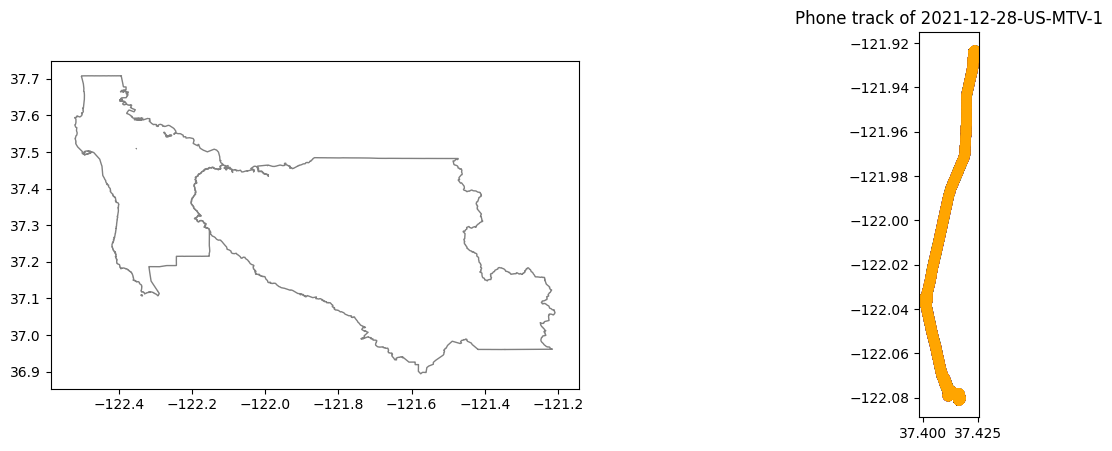

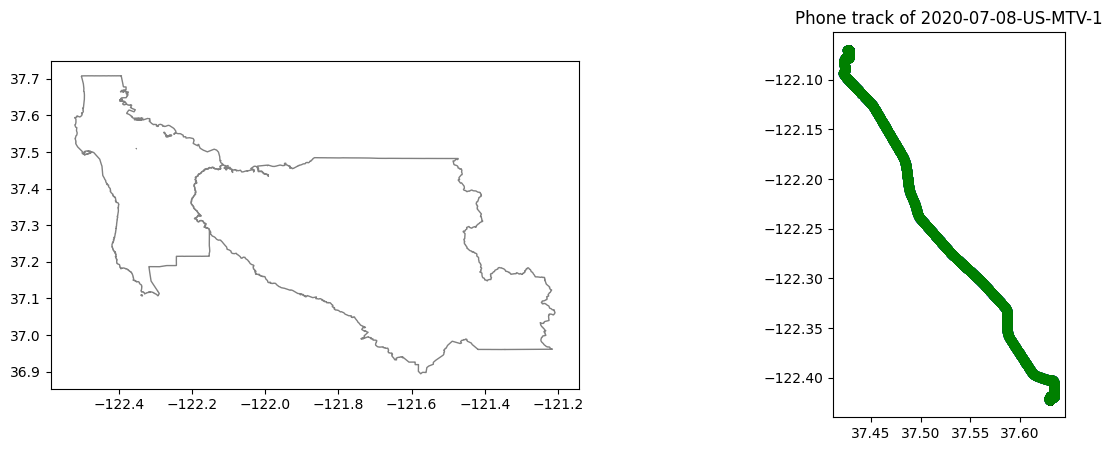

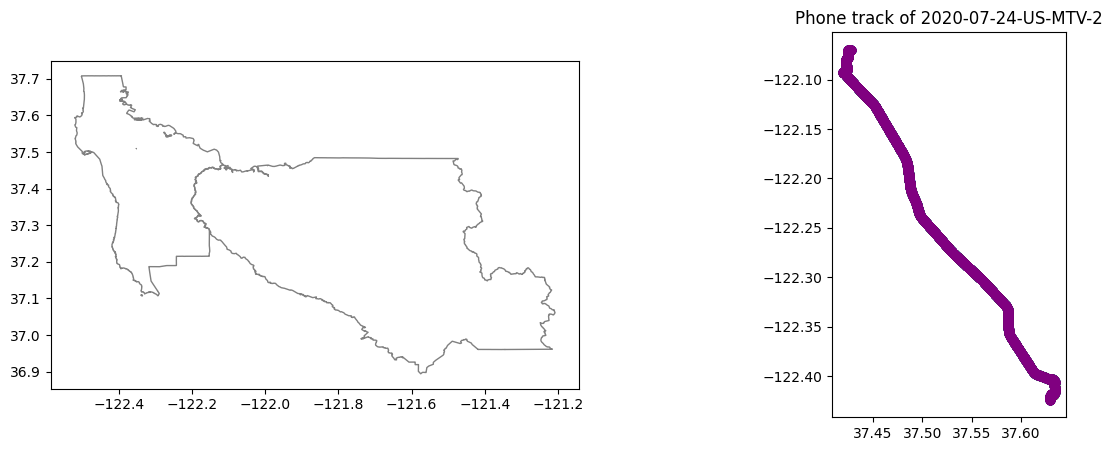

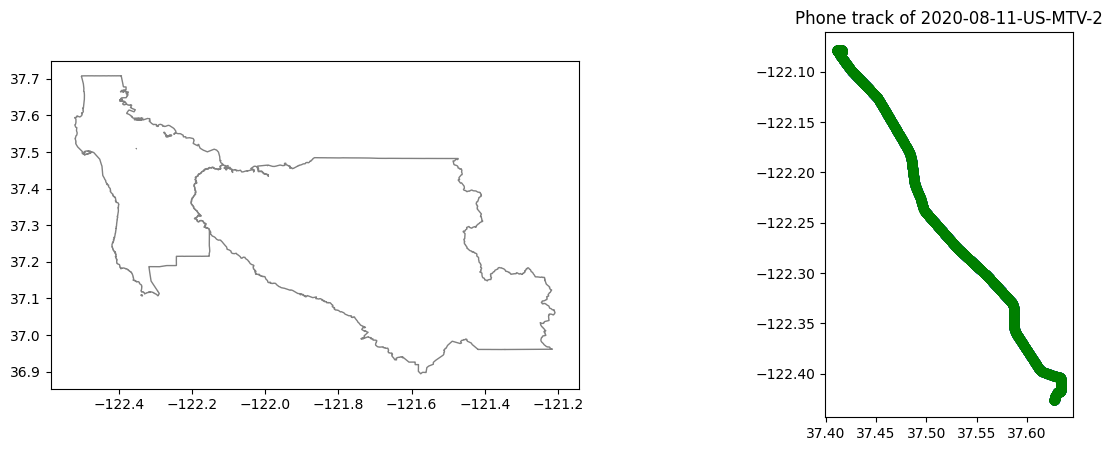

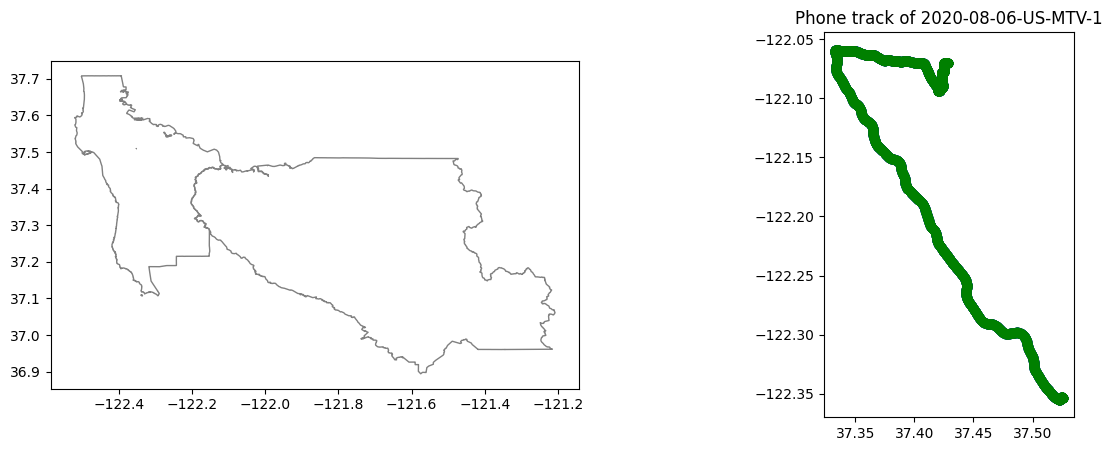

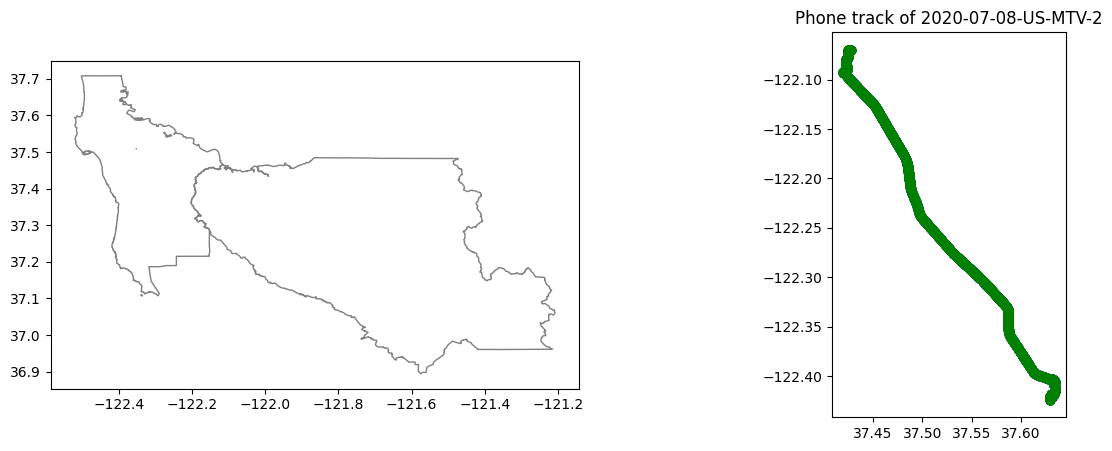

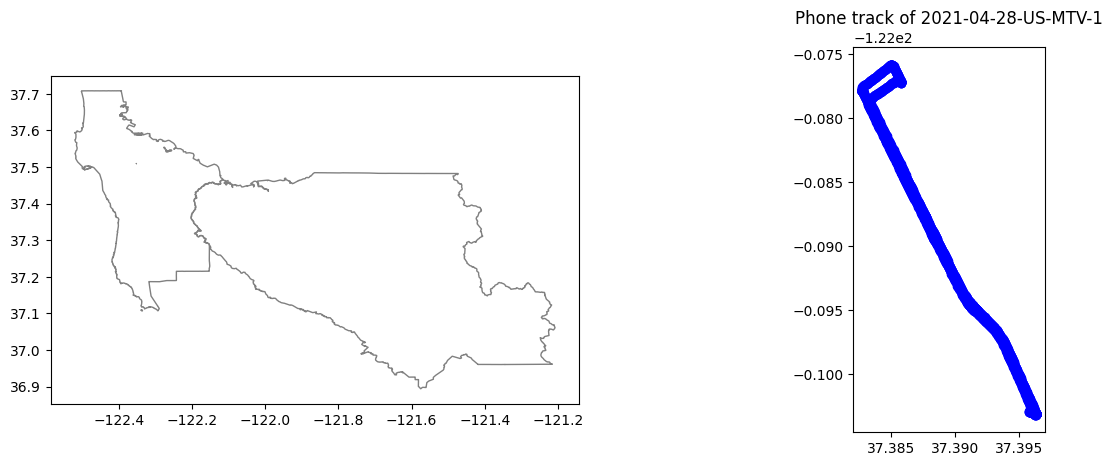

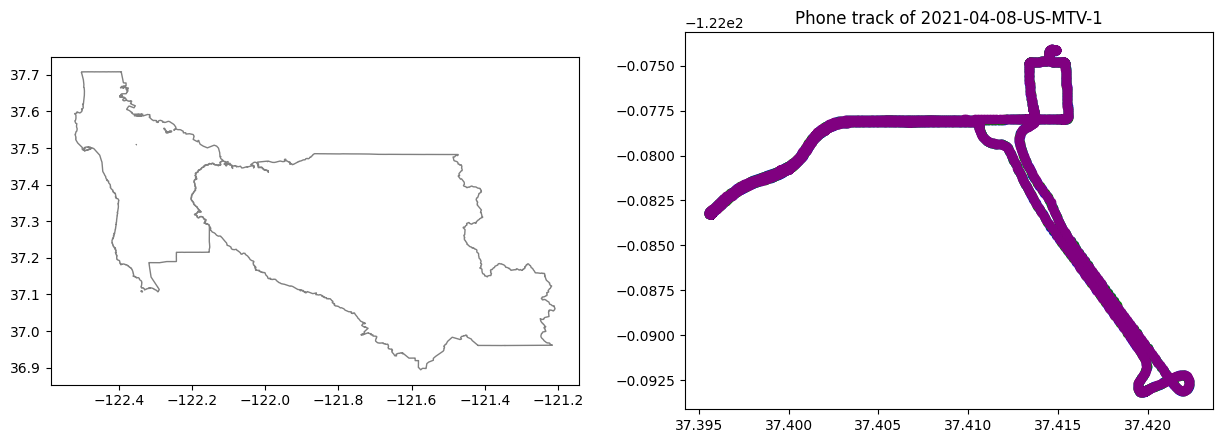

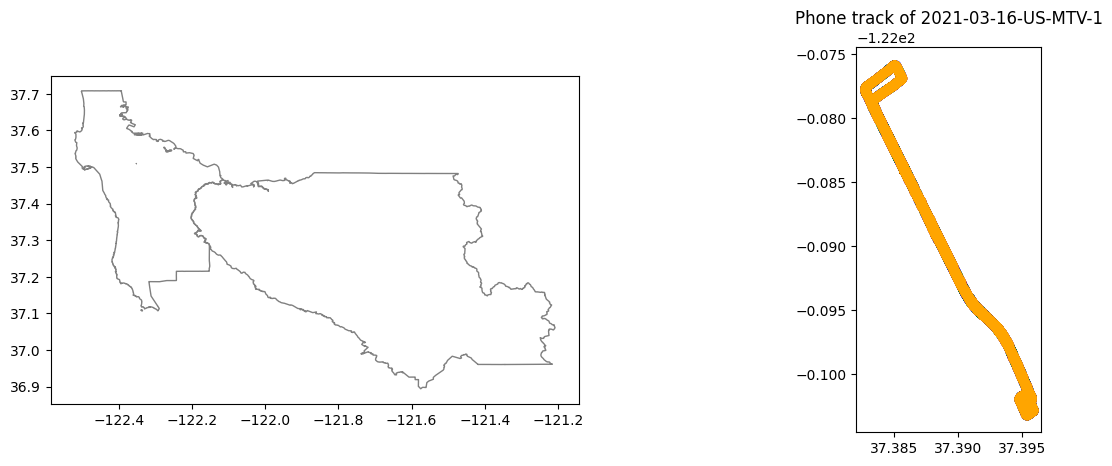

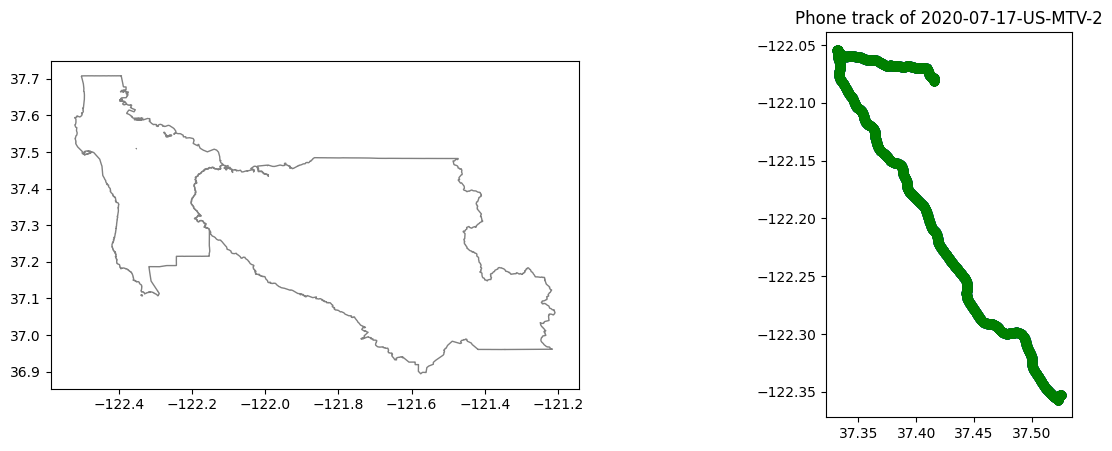

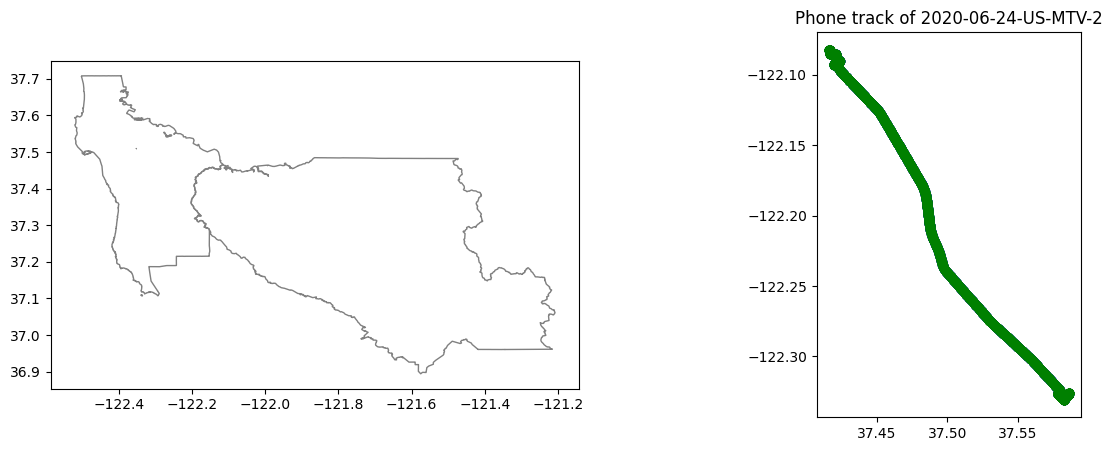

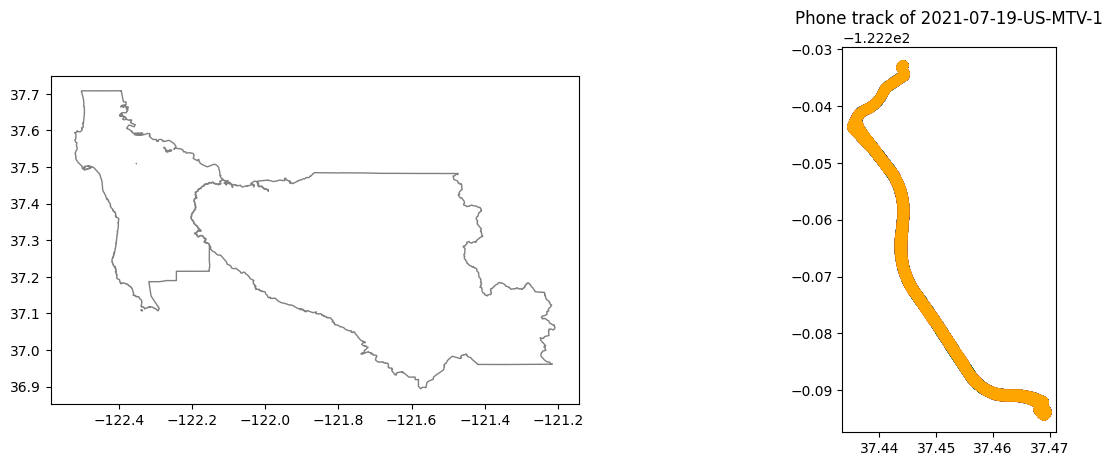

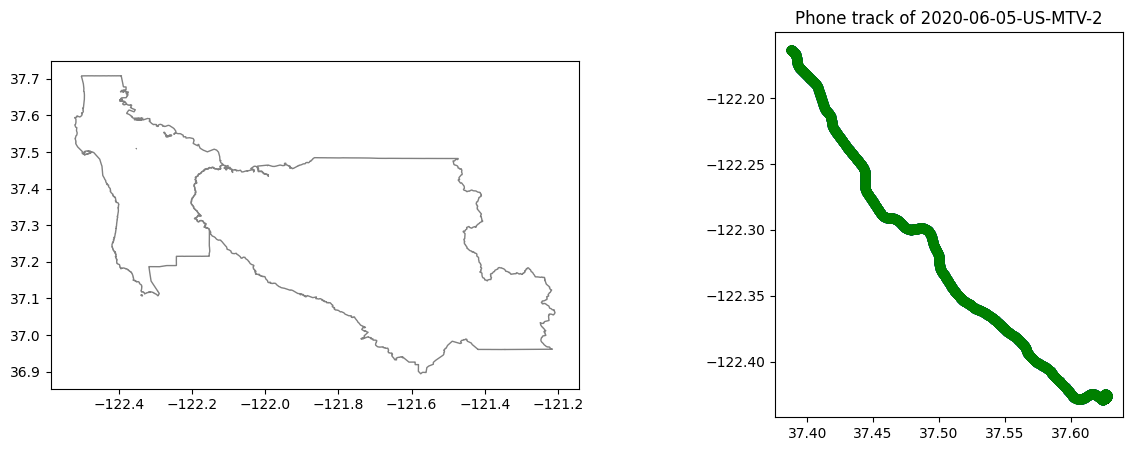

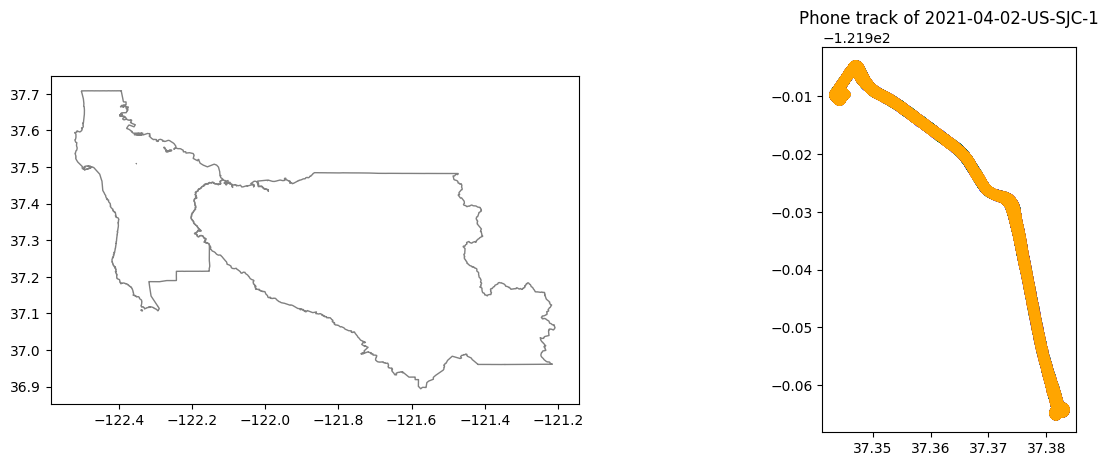

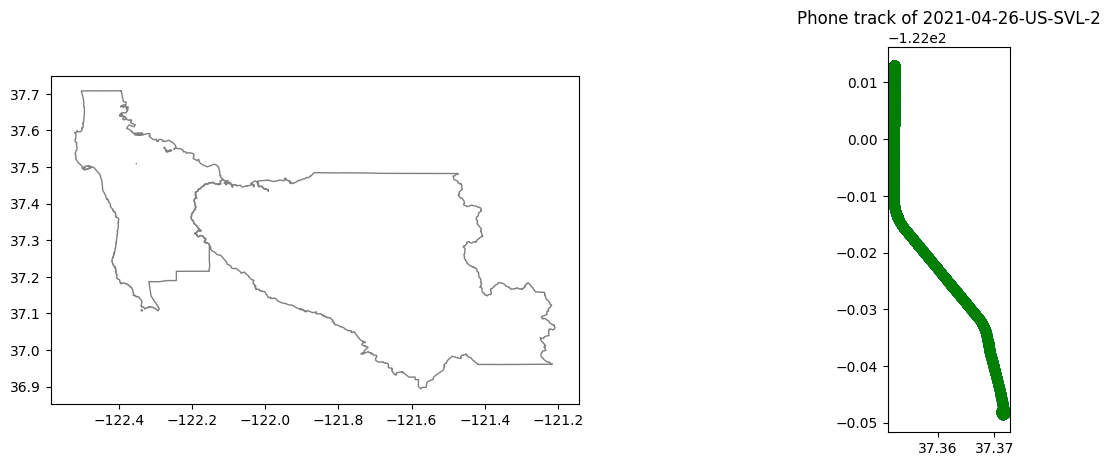

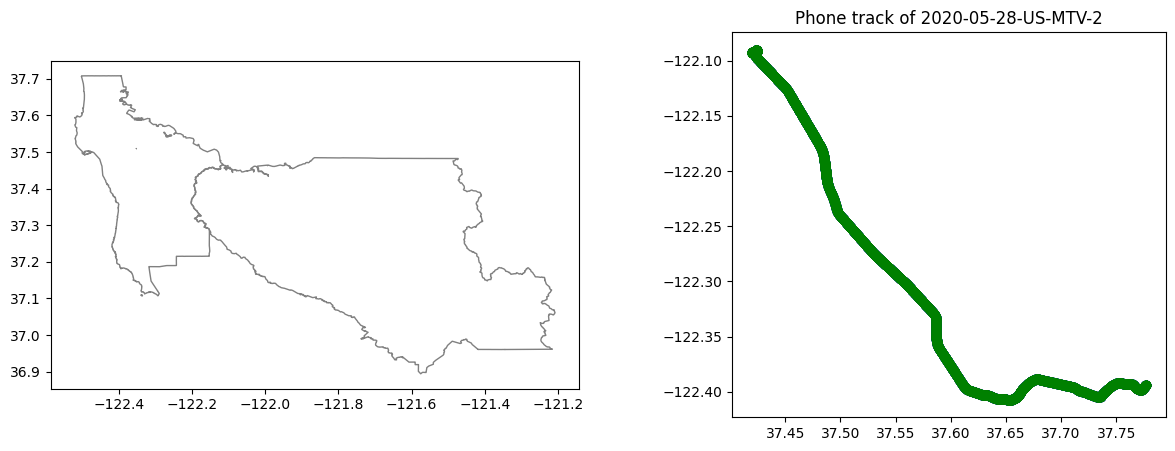

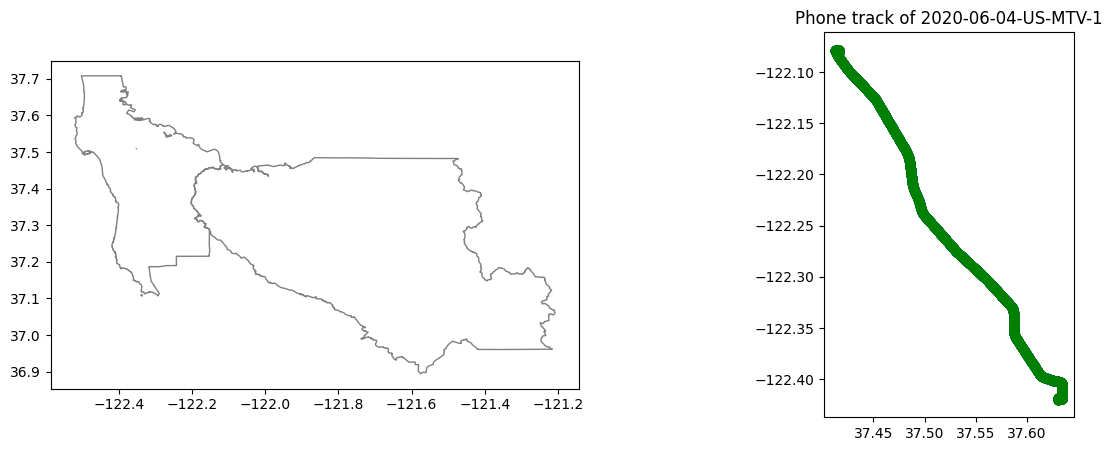

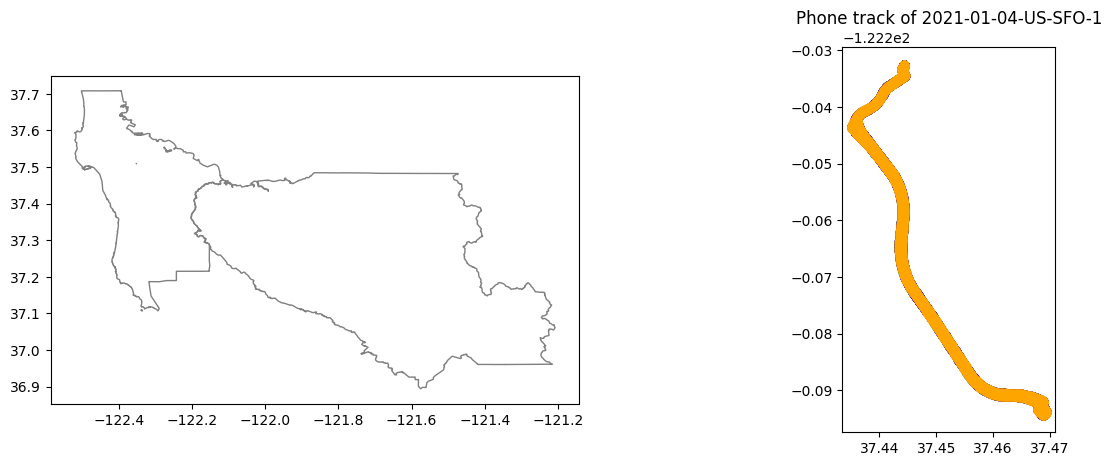

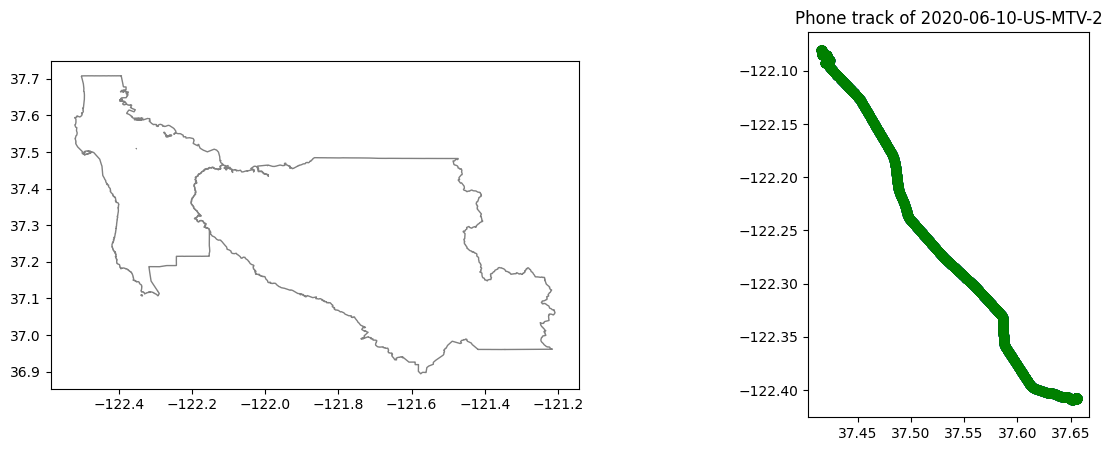

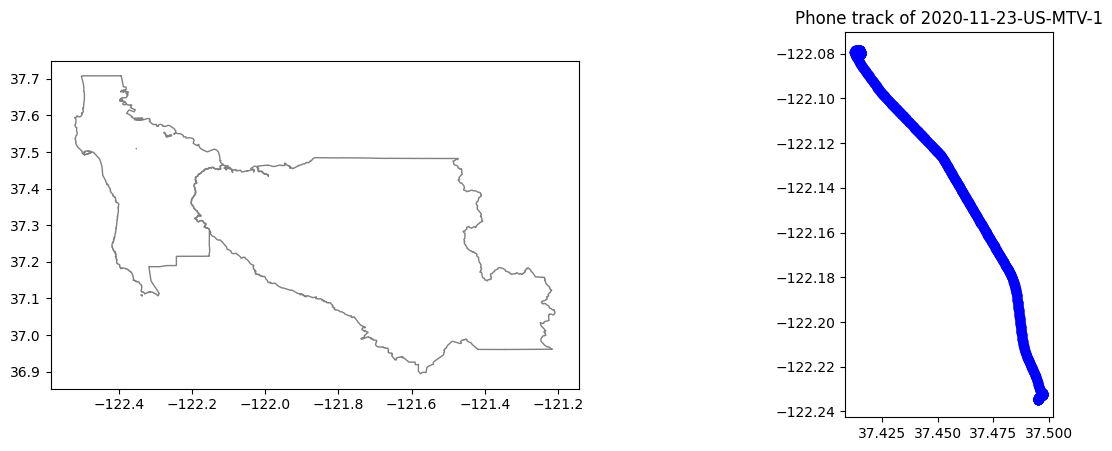

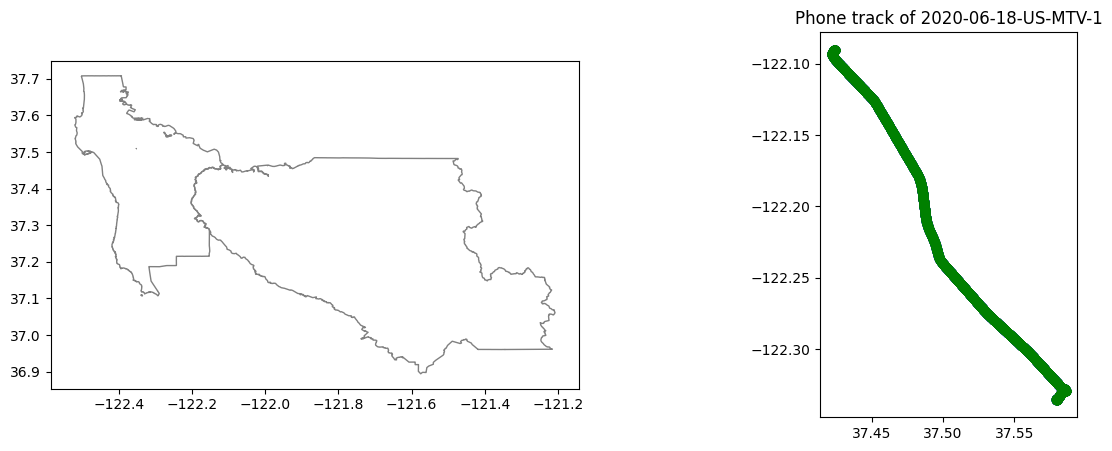

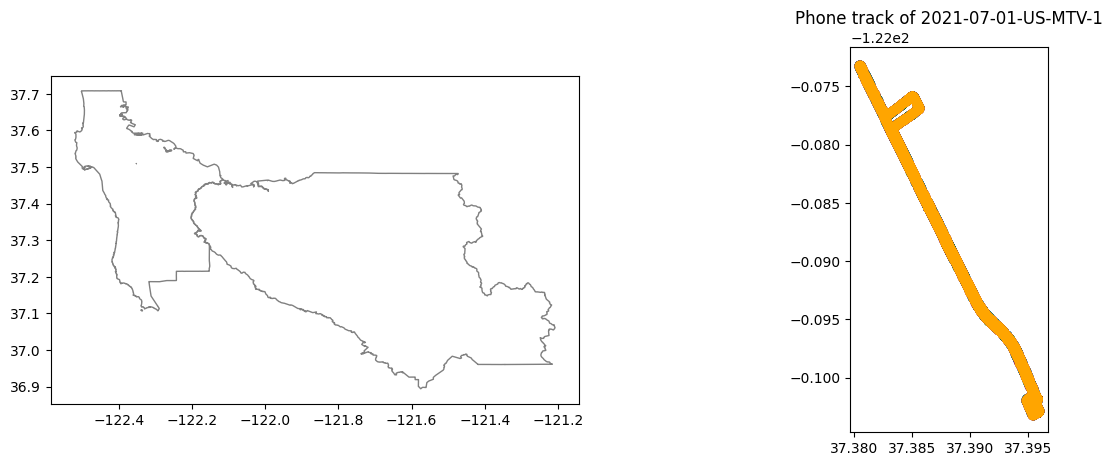

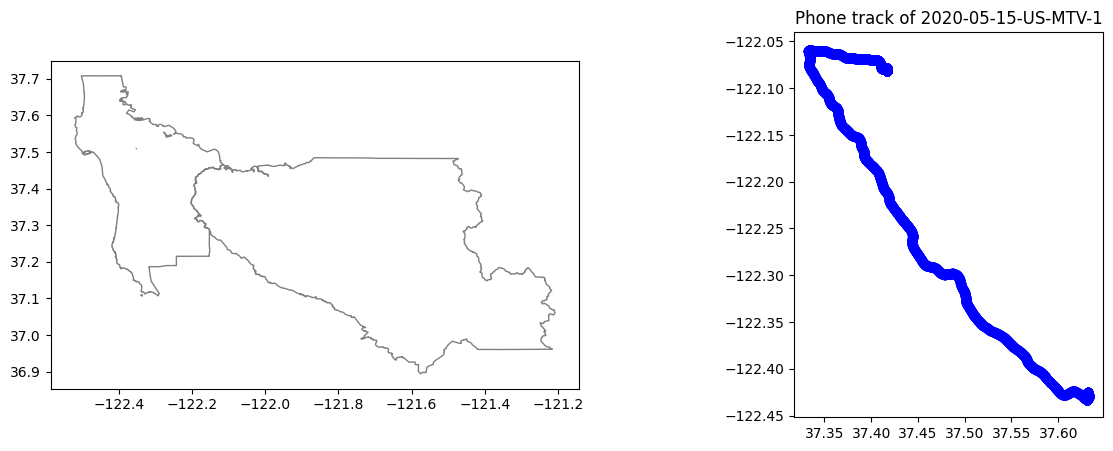

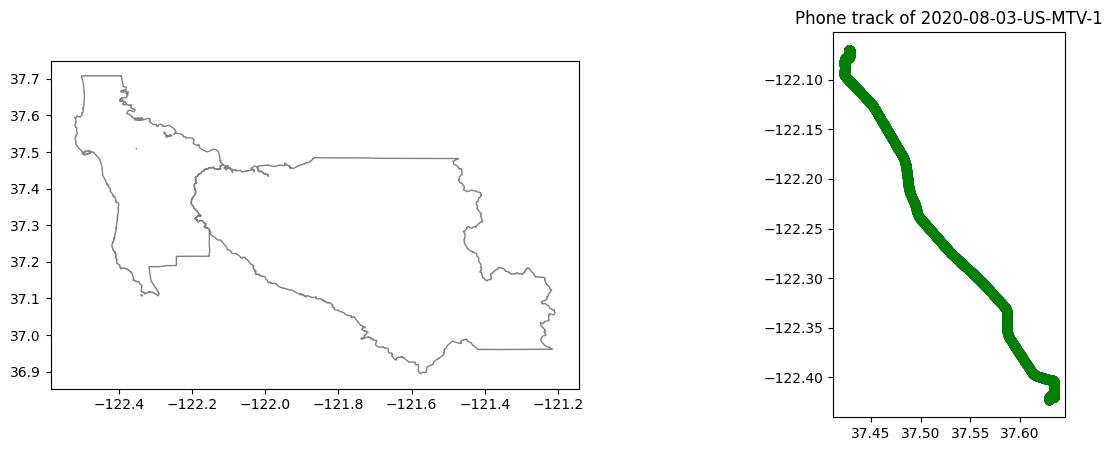

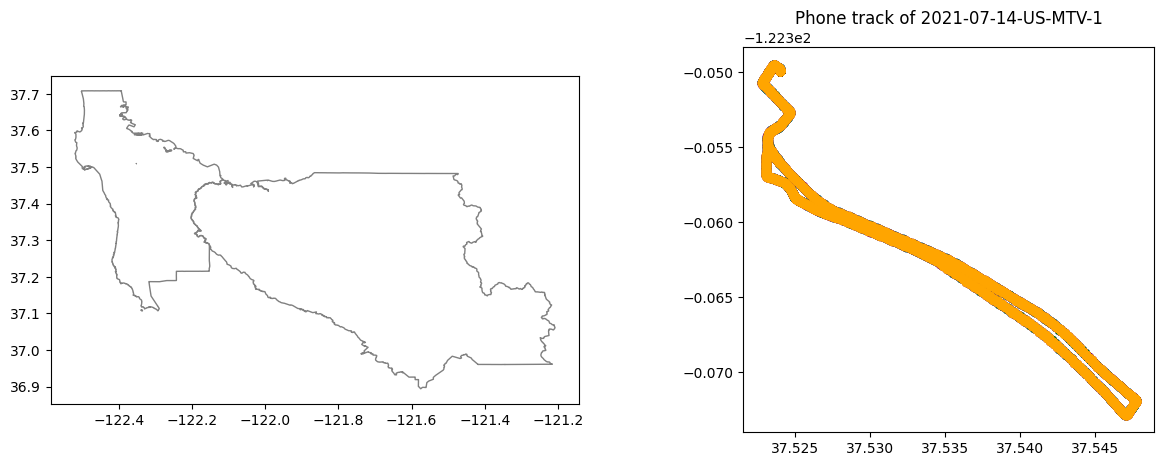

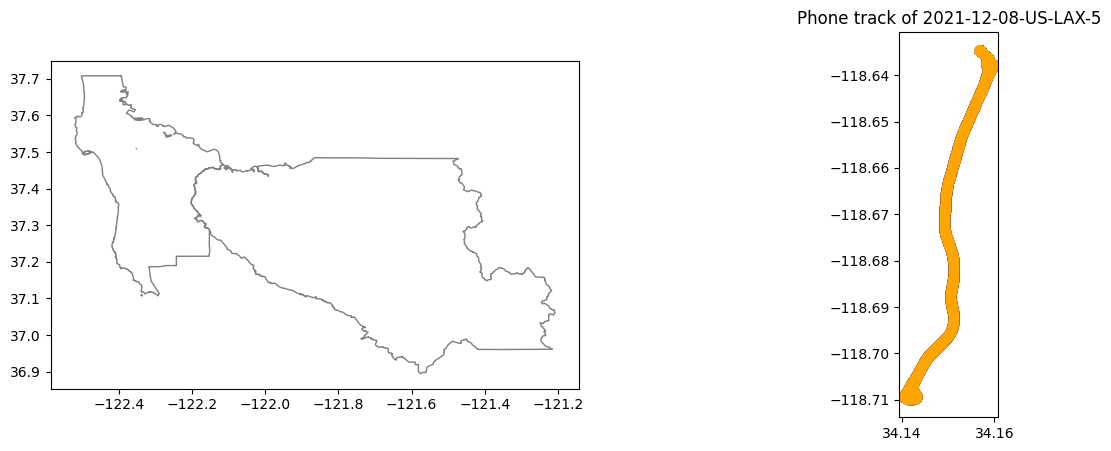

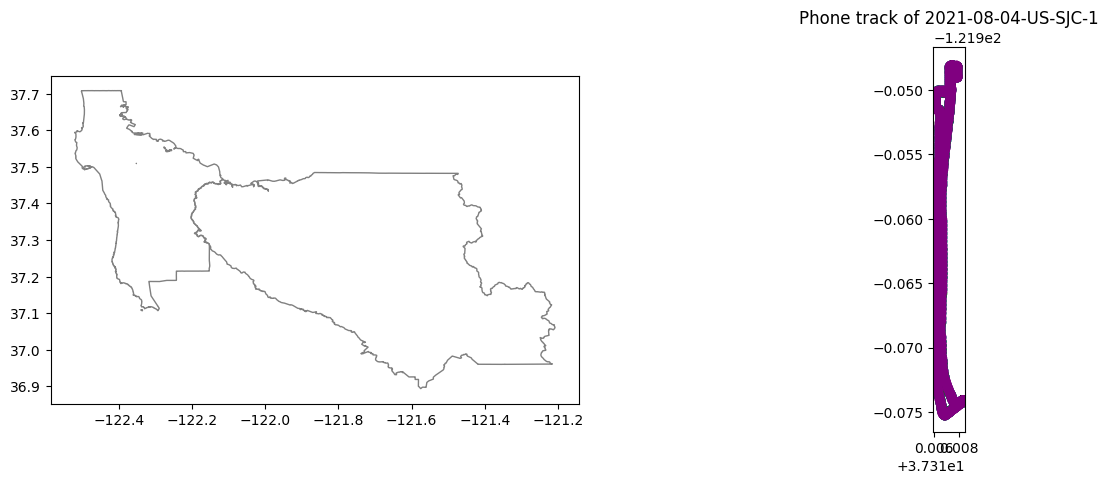

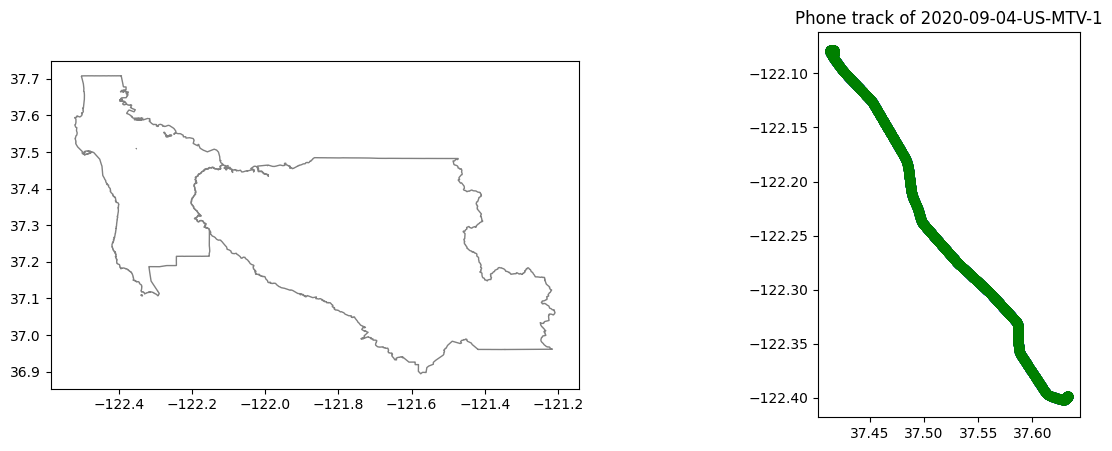

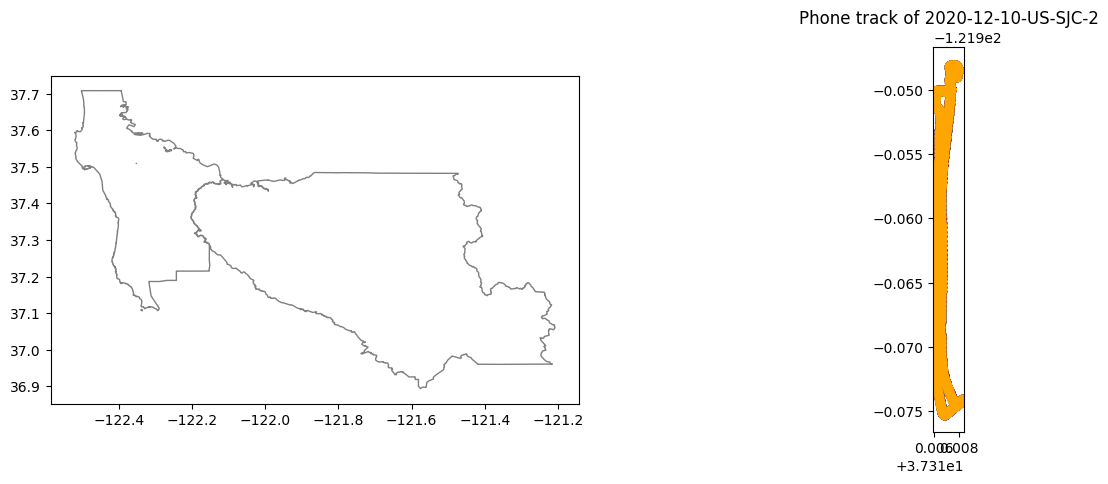

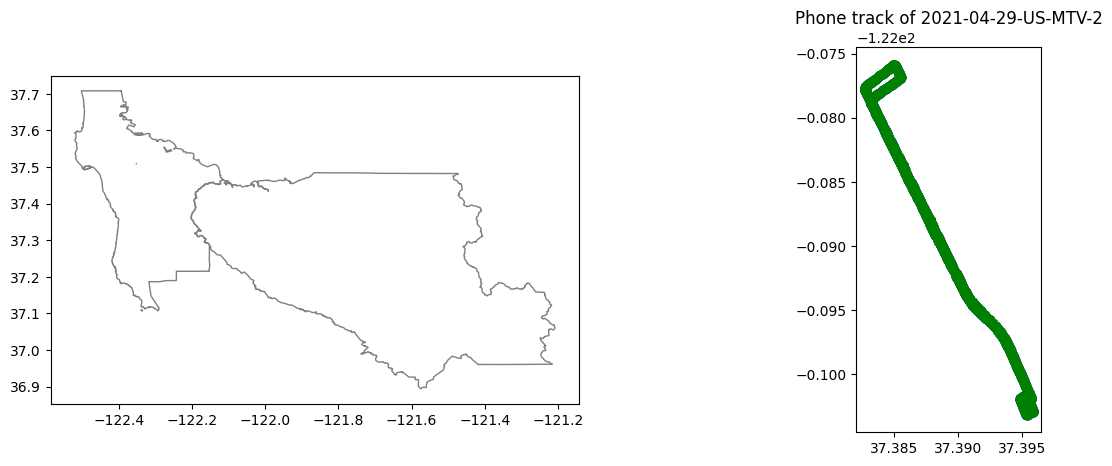

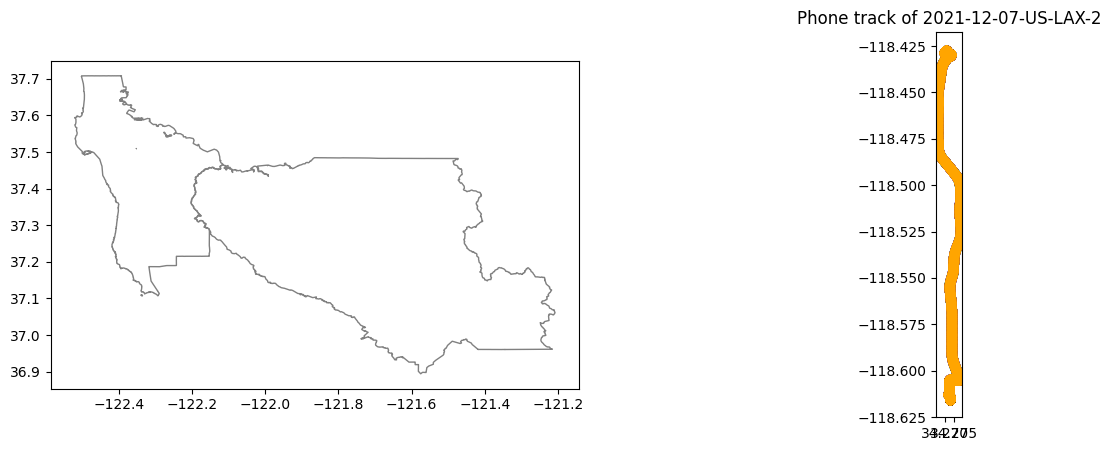

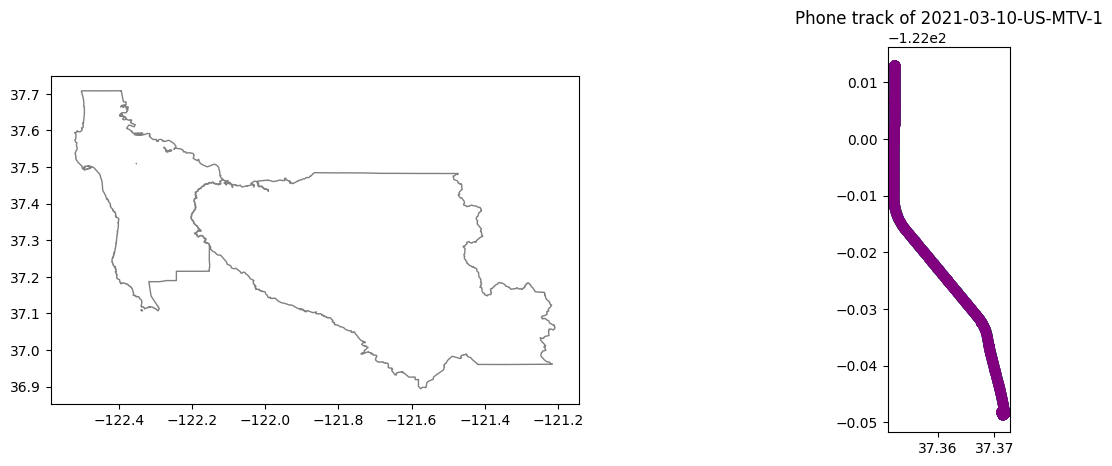

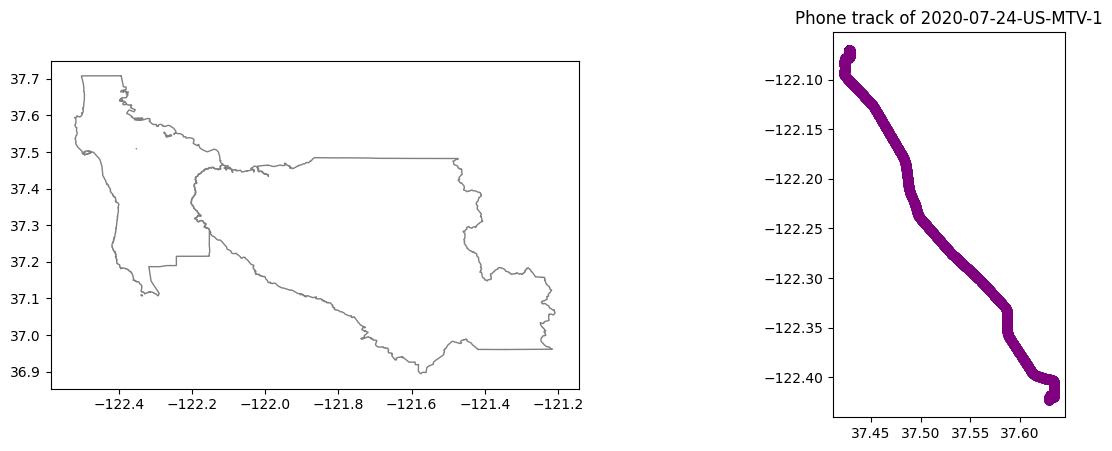

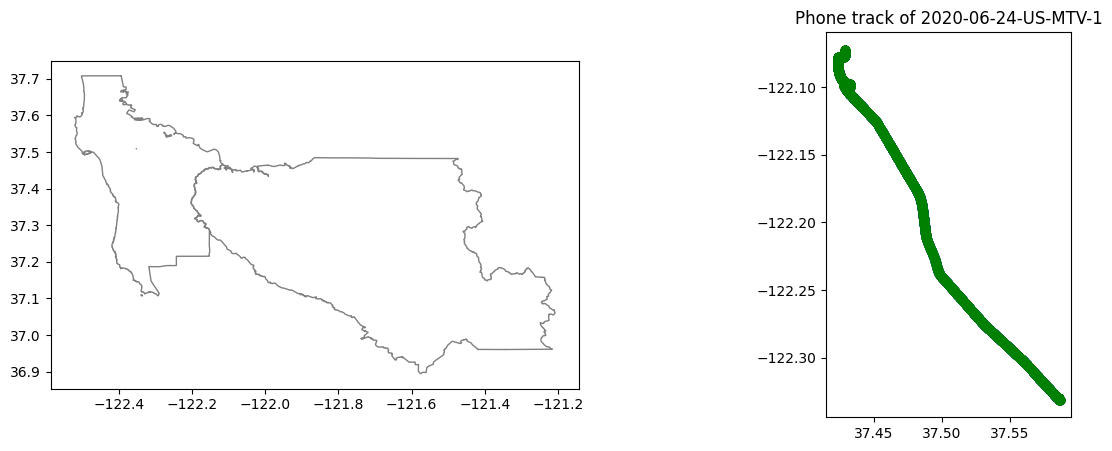

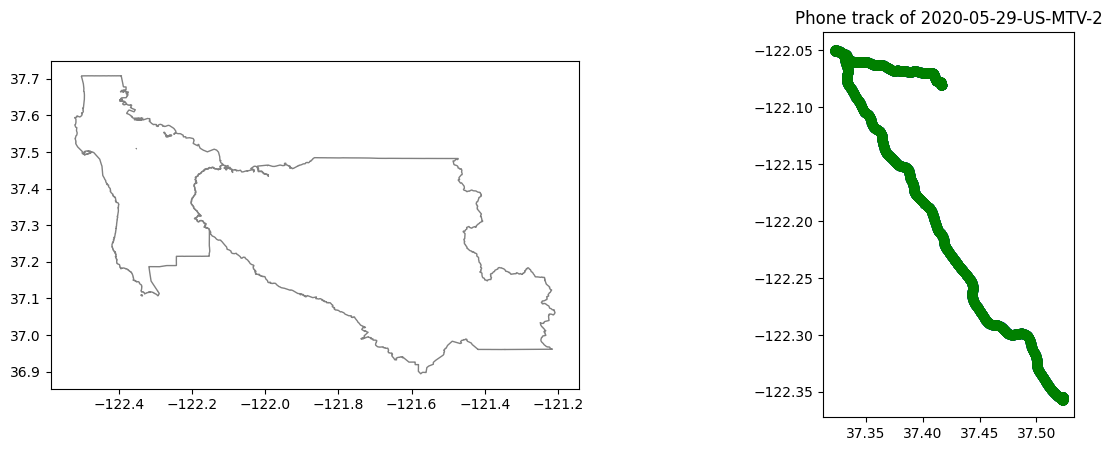

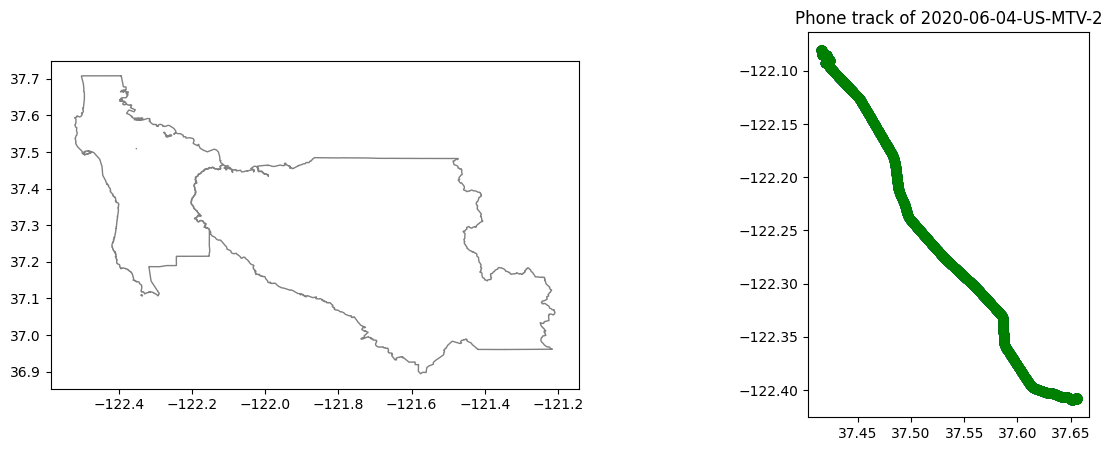

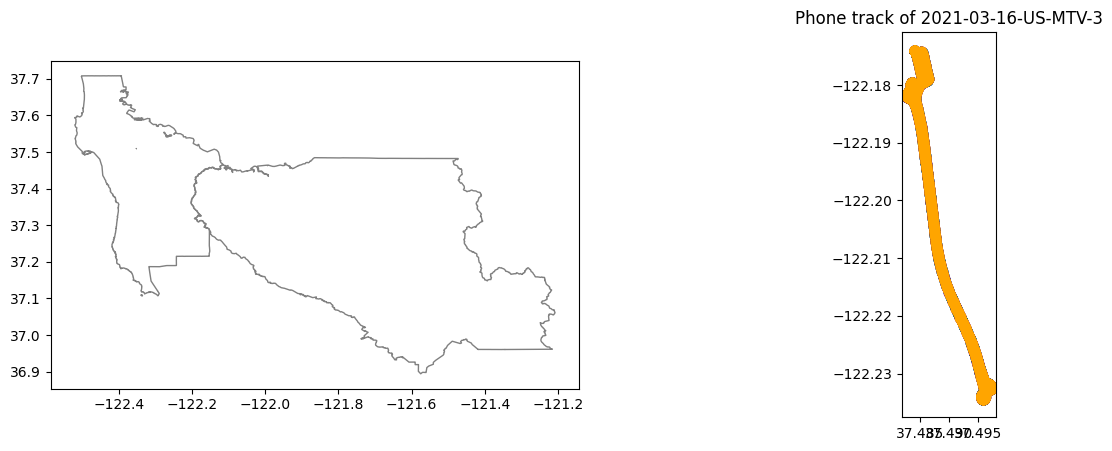

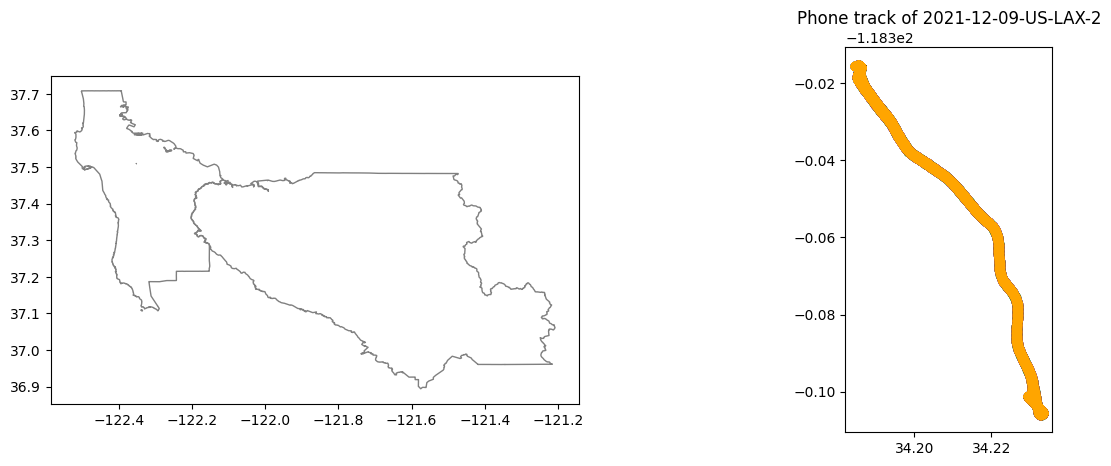

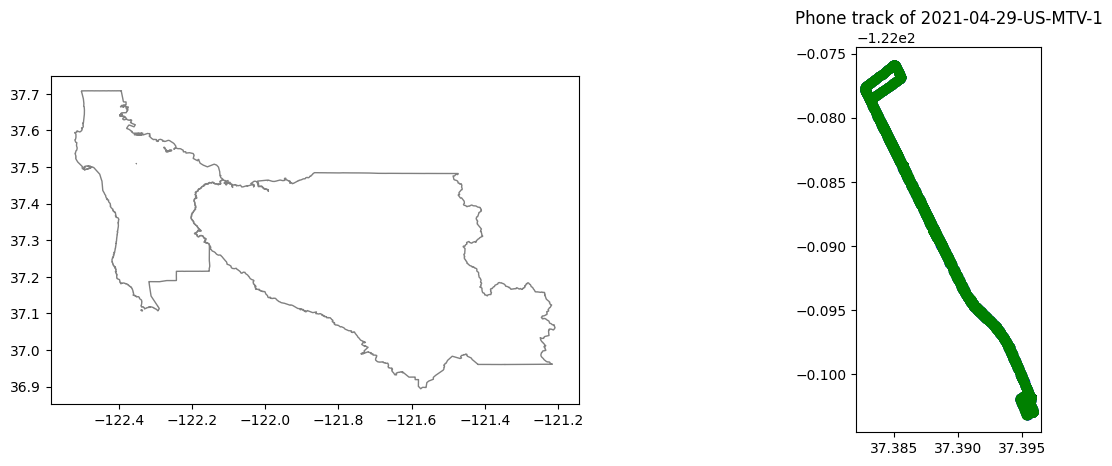

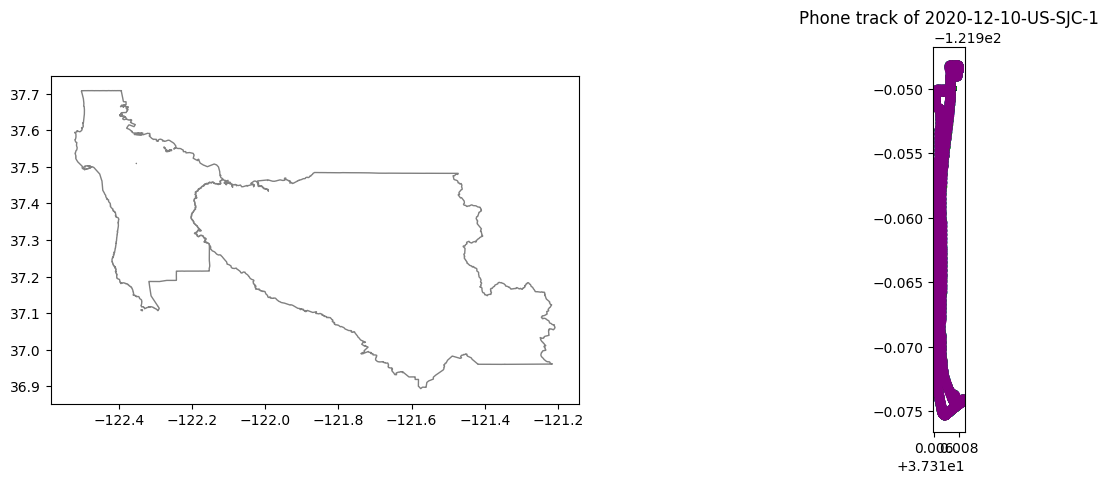

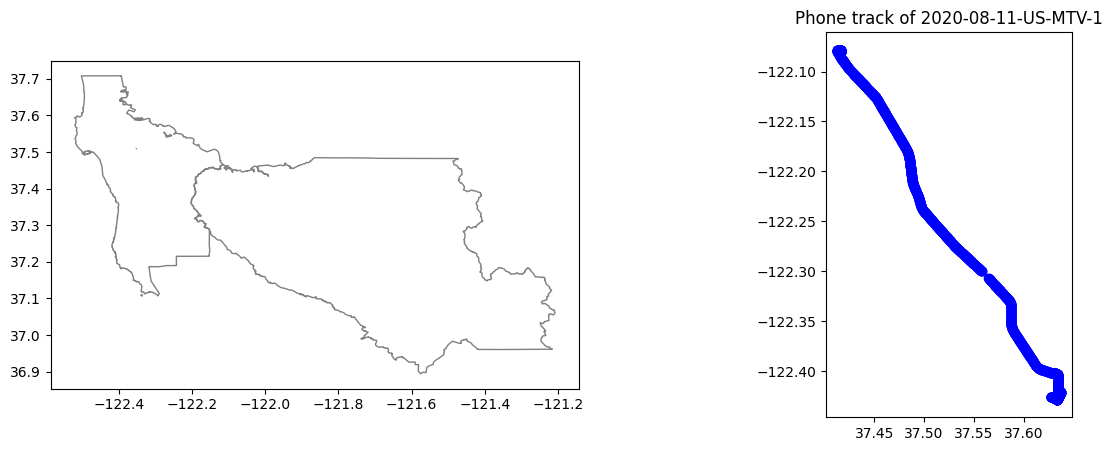

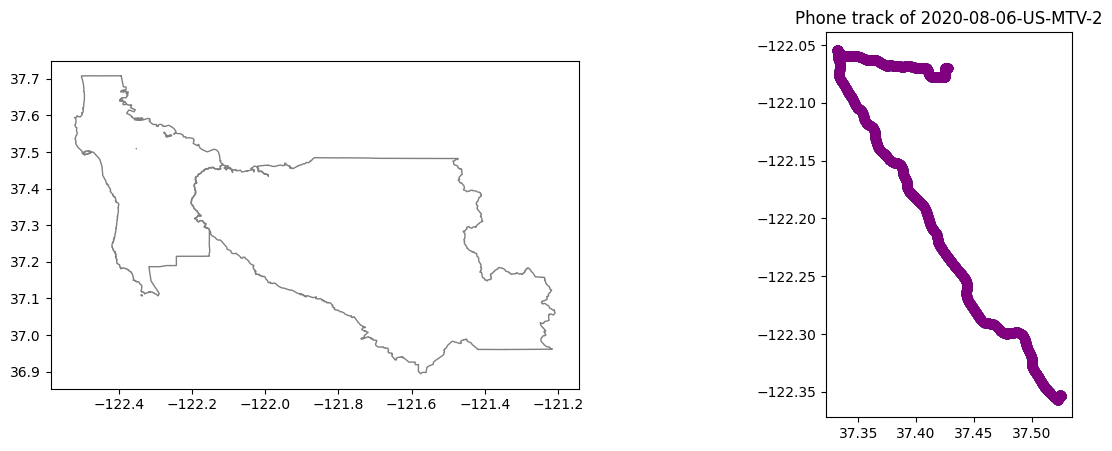

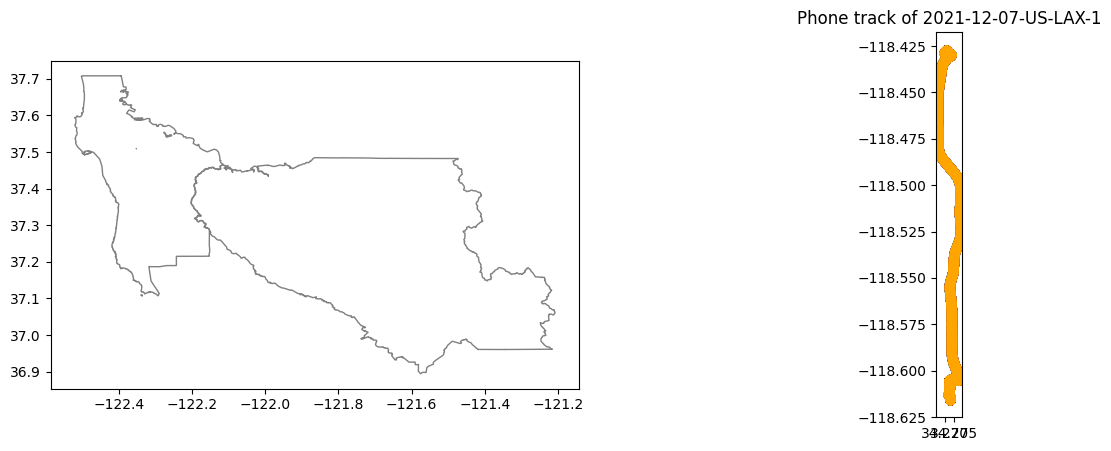

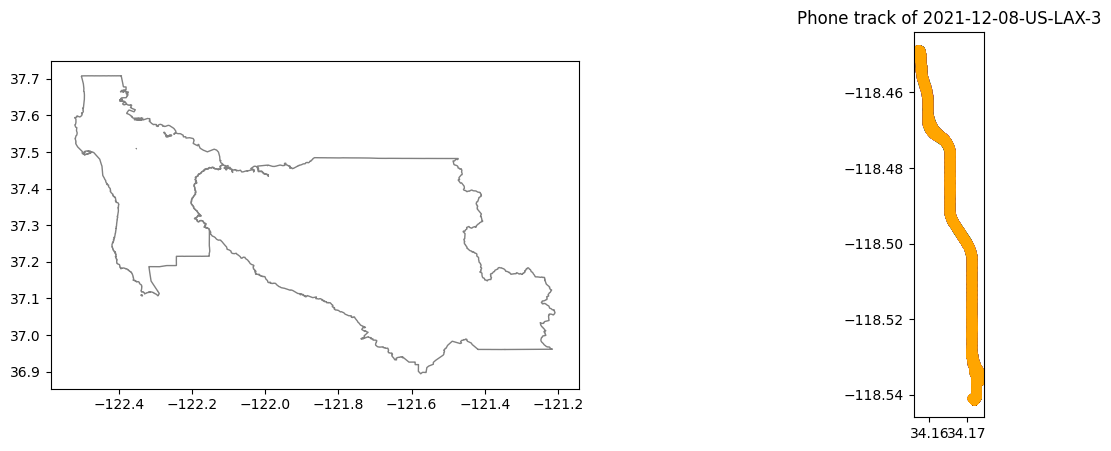

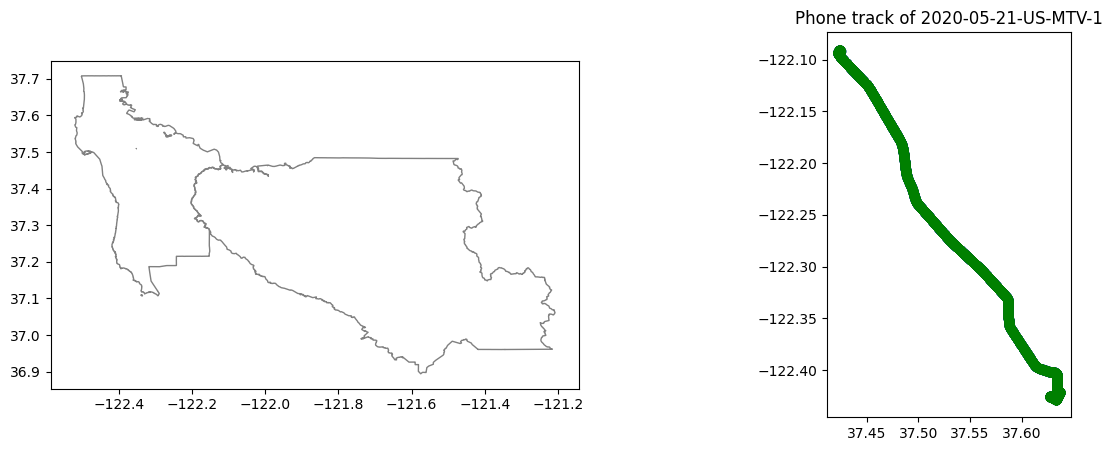

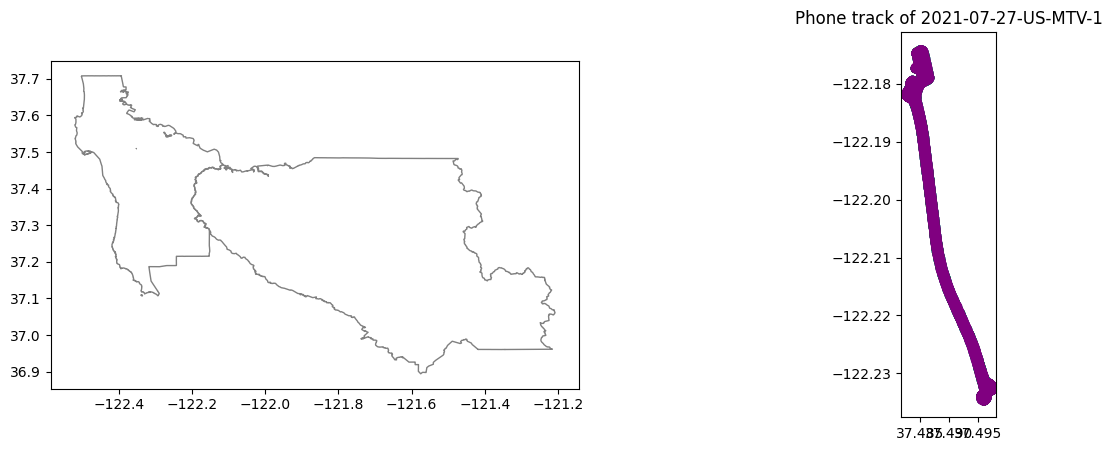

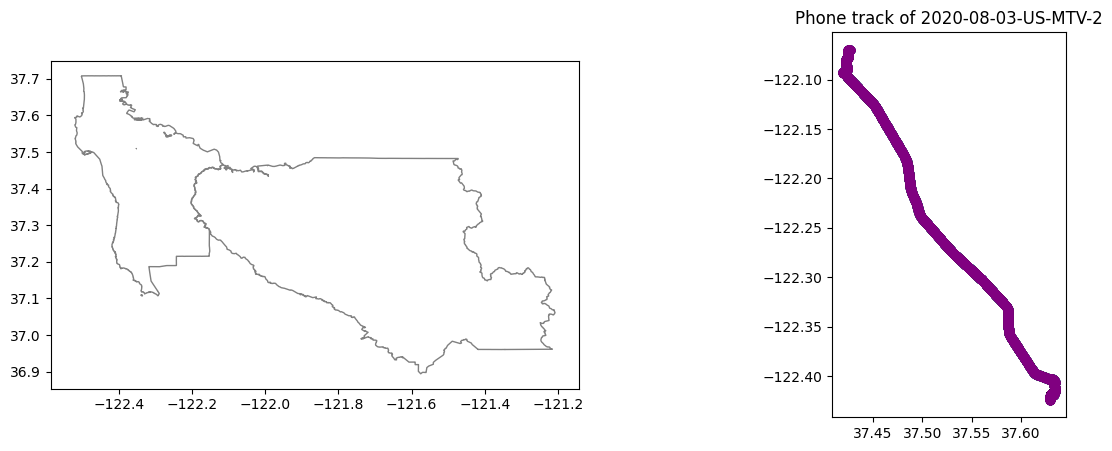

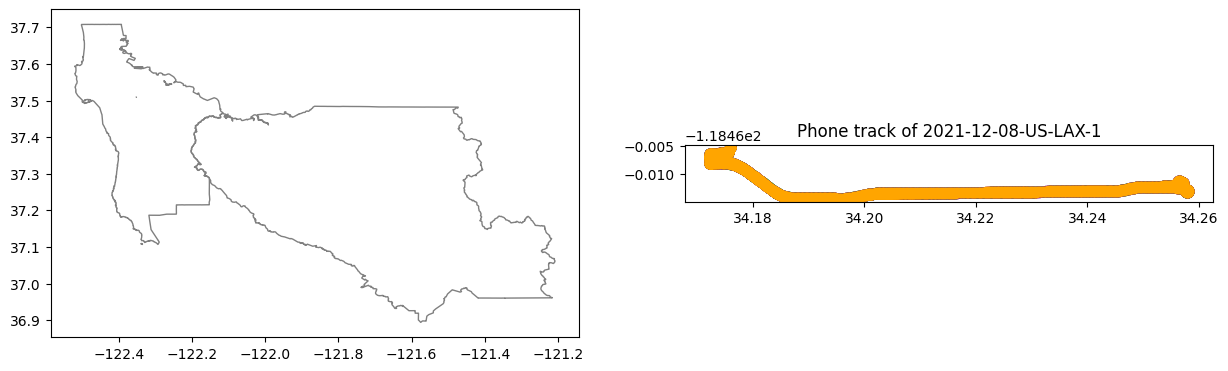

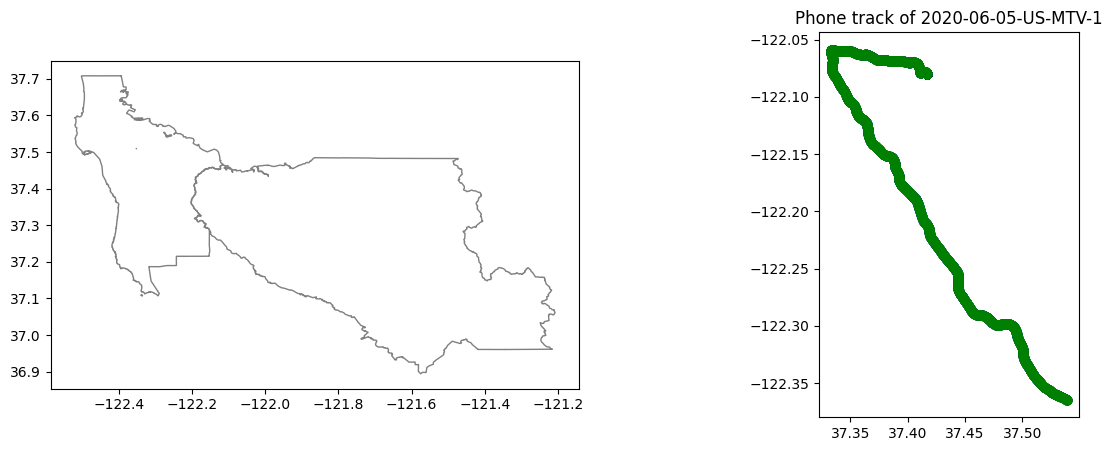

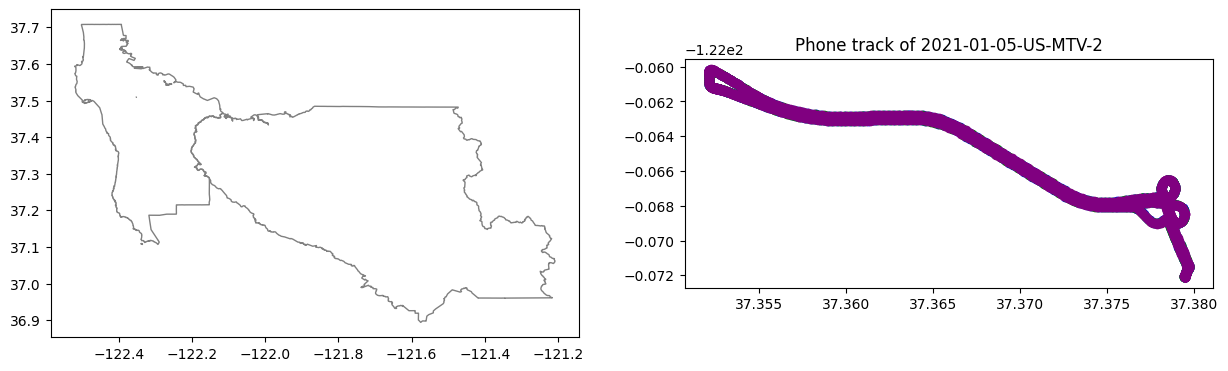

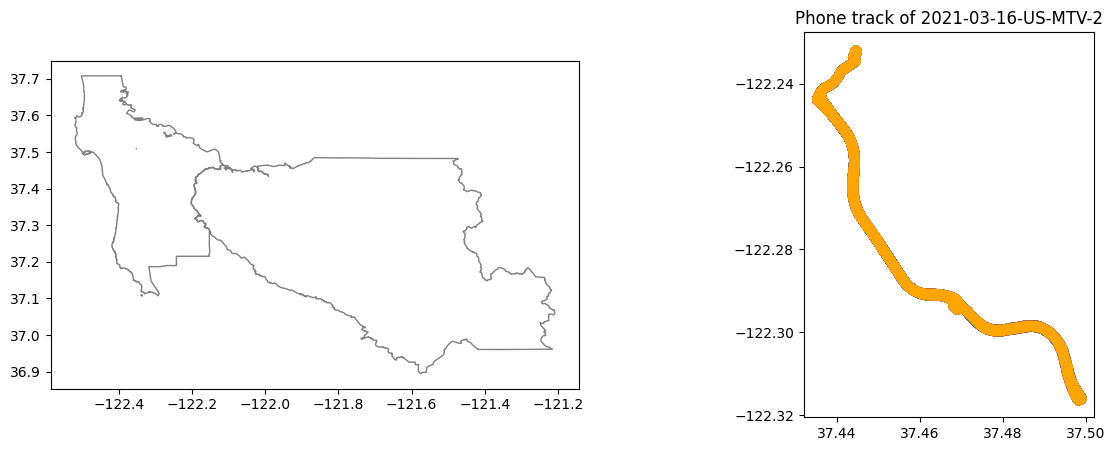

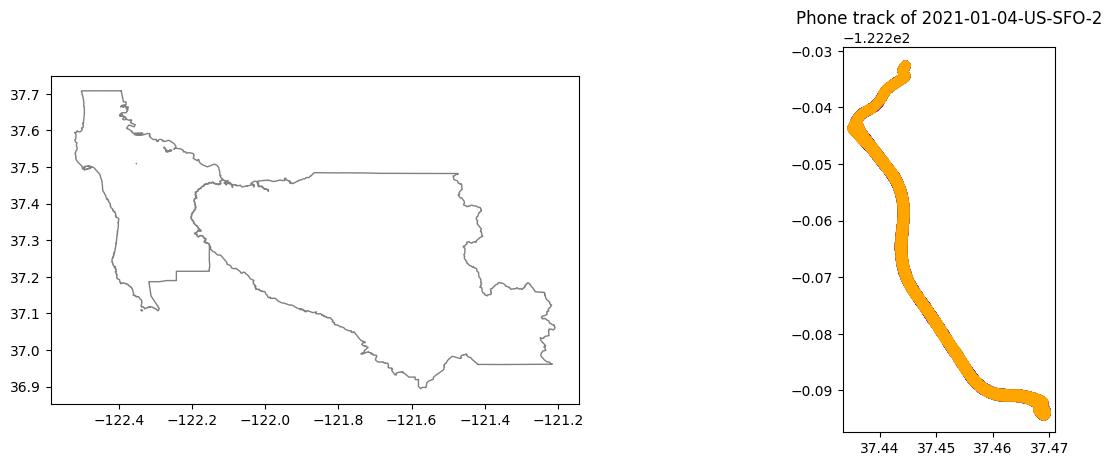

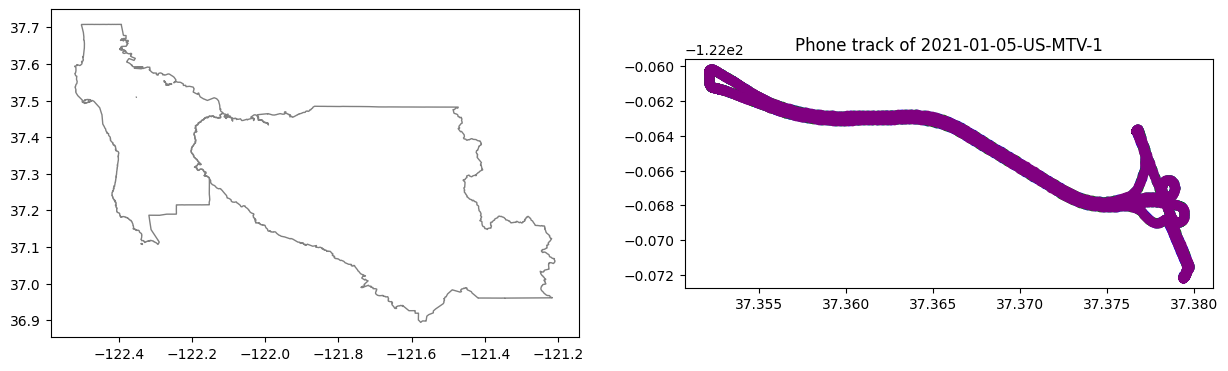

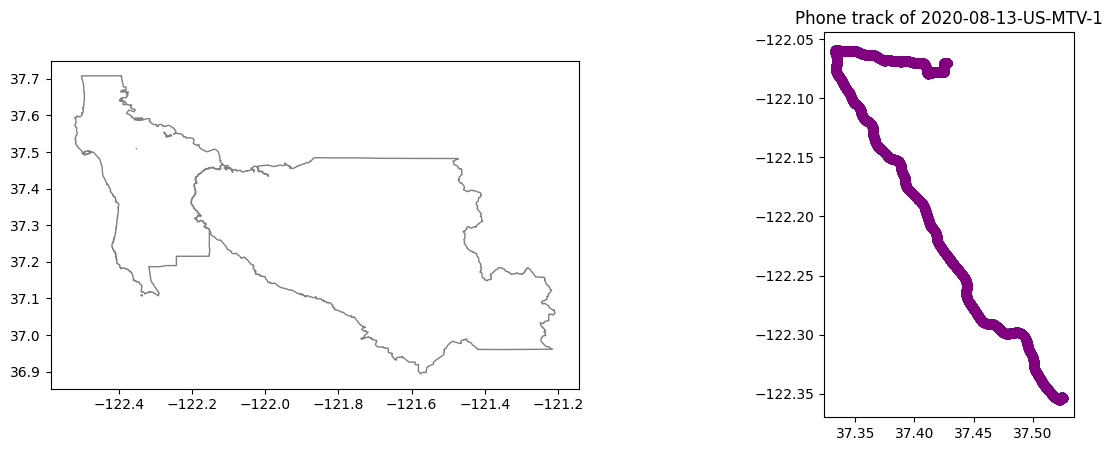

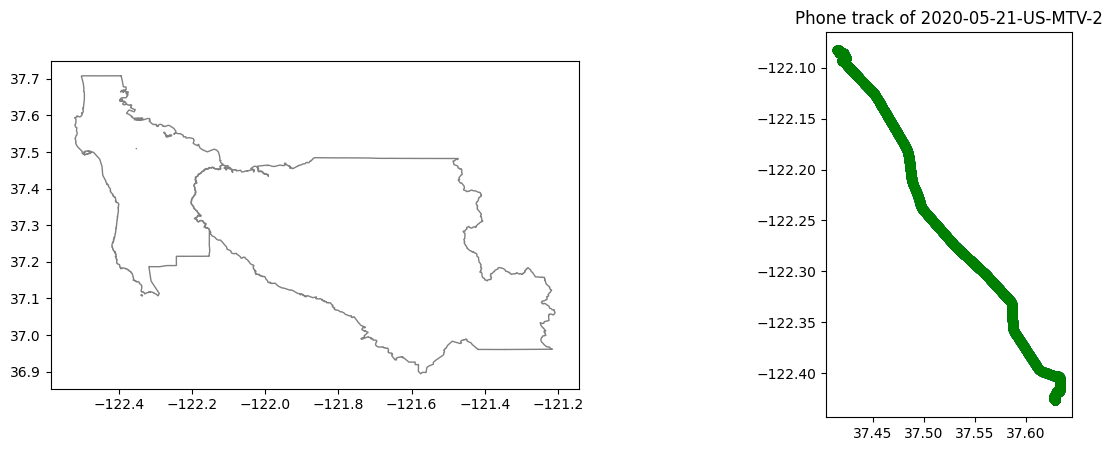

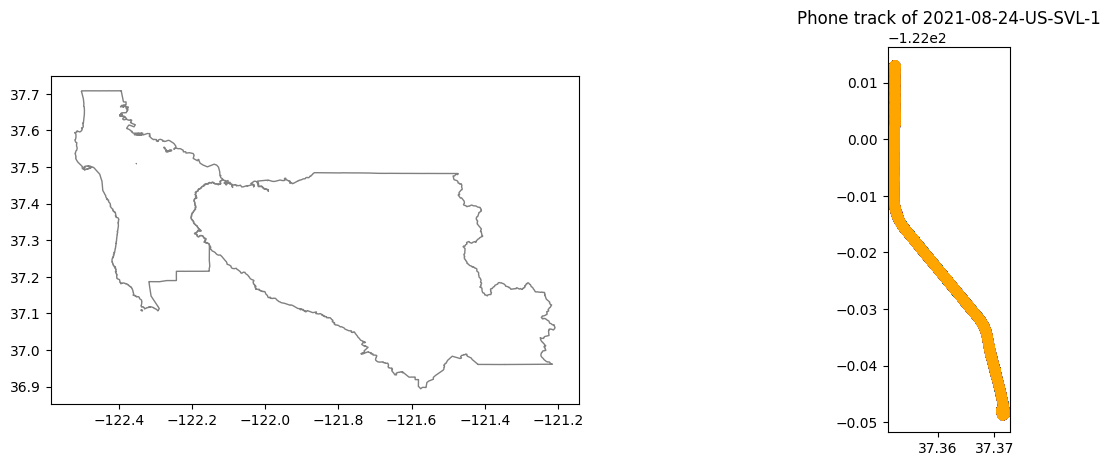

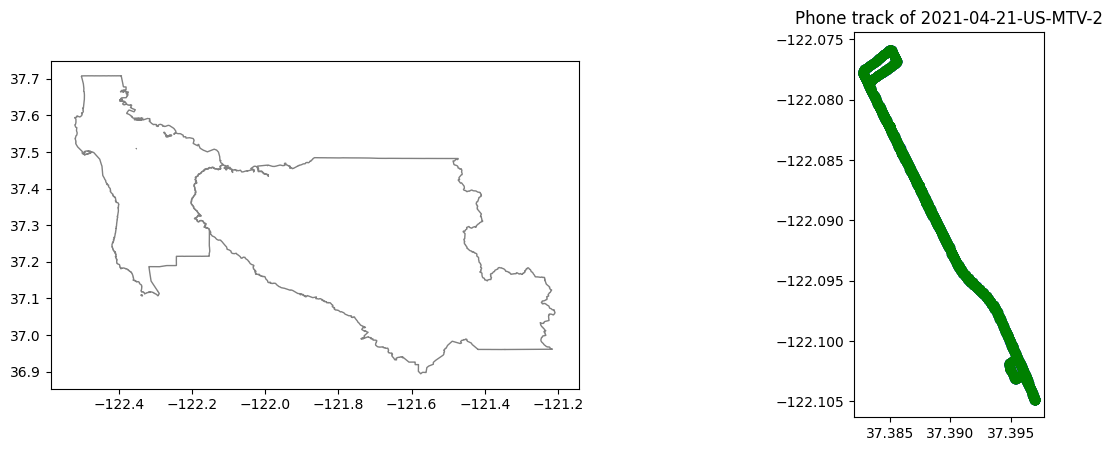

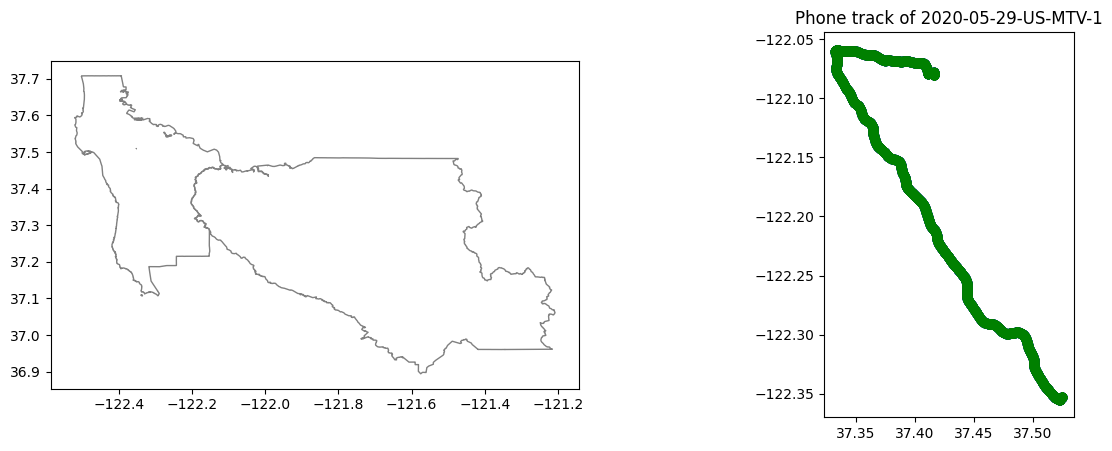

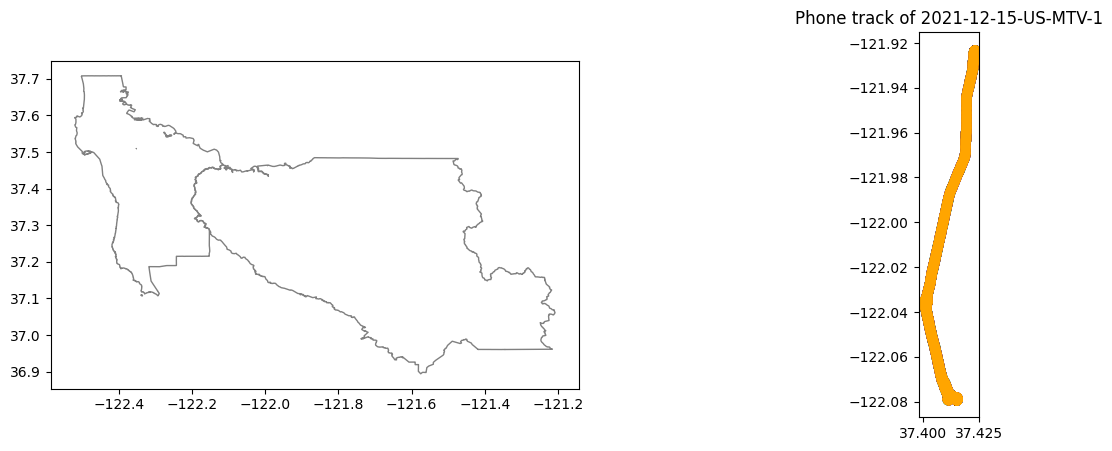

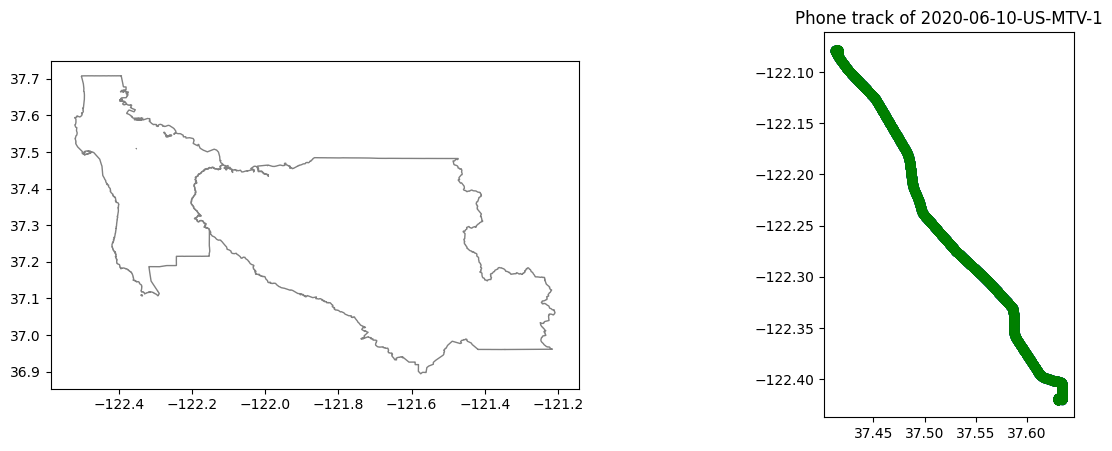

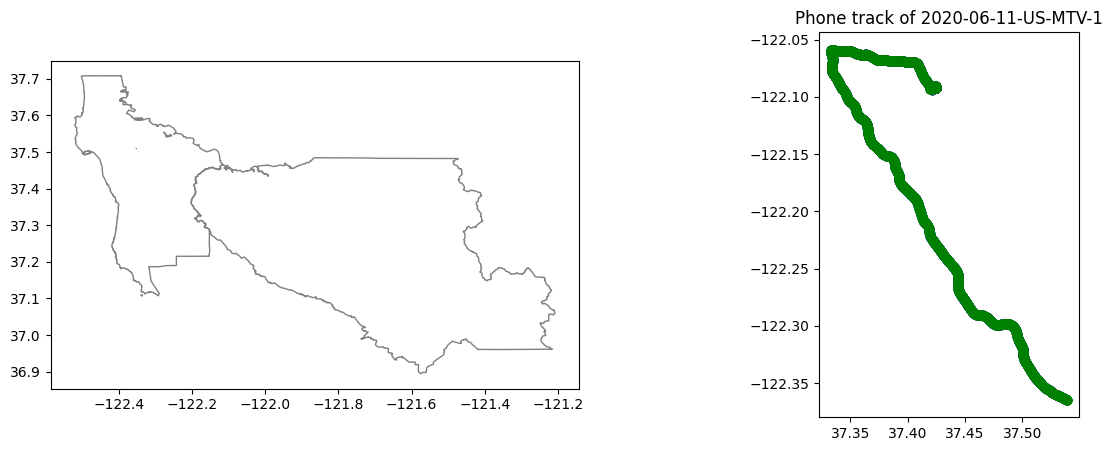

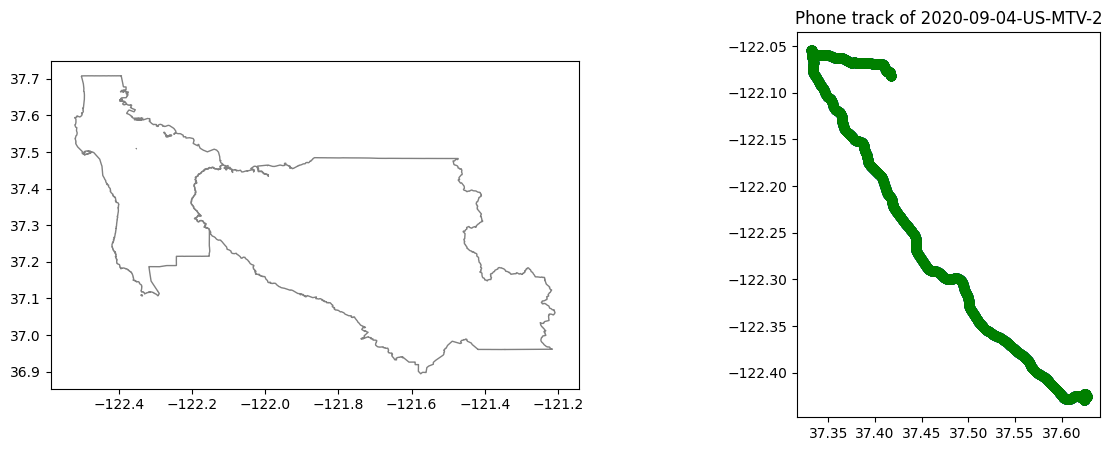

In [73]:
for collectionName, gdfs_each_collectionName in zip(collectionNames, gdfs):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    gdf_bayarea.plot(figsize=(10,10), color='none', edgecolor='gray', zorder=5, ax=axs[0])
    for i, gdf in enumerate(gdfs_each_collectionName):
        g2 = gdf.plot(color=colors[i], ax=axs[1])
        g2.set_title(f"Phone track of {collectionName}")

In [74]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [78]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np

# Example dataset - Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for mixed data types in y_train
print(f"Original data type of y_train: {y_train.dtype}")
print(f"Unique values in y_train: {np.unique(y_train)}")

# If necessary, convert y_train to a single data type (e.g., integers or strings)
# In this case, since the Iris dataset labels are already integers, this step is not necessary.
# But if you have mixed types, you could use one of the following conversions:

# Convert to strings (if needed)
# y_train = y_train.astype(str)

# OR Convert to integers using LabelEncoder (if y_train contains strings representing categories)
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)

# Now, fit the LightGBM model
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Output the predictions
print("Predictions:", y_pred)


Original data type of y_train: int64
Unique values in y_train: [0 1 2]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.073920
[LightGBM] [Info] Start training from score -1.123930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [79]:
import lightgbm as lgb
clf=lgb.LGBMClassifier()
clf.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.073920
[LightGBM] [Info] Start training from score -1.123930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

LGBMClassifier()

In [80]:
LGBMClassifier()

NameError: name 'LGBMClassifier' is not defined

In [81]:
y_pred=clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)
print('LightGBM Model Accuracy score:{0:0.4f}'.format(accuracy_score(y_test,y_pred)))

LightGBM Model Accuracy score:1.0000


In [83]:
y_pred_train=clf.predict(X_train)

In [84]:
print('Training-set accuracy score:{0:0.4f}'.format(accuracy_score(y_train,y_pred_train)))

Training-set accuracy score:1.0000


In [85]:
print('Training set score:{:.4f}'.format(clf.score(X_train,y_train)))
print('Test set score:{:.4f}'.format(clf.score(X_test,y_test)))

Training set score:1.0000
Test set score:1.0000


In [86]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
print('Confusion matrix\n\n',cm)
print('\n True Positives(TP)= ',cm[0,0])
print('\n True Negatives(TN)= ',cm[1,1])
print('\n False Positives(FP)= ',cm[0,1])
print('\n False Negatives(FN)= ',cm[1,0])

Confusion matrix

 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

 True Positives(TP)=  10

 True Negatives(TN)=  9

 False Positives(FP)=  0

 False Negatives(FN)=  0


In [87]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_test)

array([0, 1, 2])

In [88]:
def plot(y_true,y_pred):
    labels=unique_labels(y_test)
    columns=[f'Predicted{label}' for label in labels]
    index=[f'Actual{label}' for label in labels]
    table=pd.DataFrame(confusion_matrix(y_true,y_pred),columns=columns,index=index)
    return table

In [89]:
plot(y_test,y_pred)

Predicted0  Predicted1  Predicted2
Actual0          10           0           0
Actual1           0           9           0
Actual2           0           0          11

In [90]:
def plot2(y_true,y_pred):
    labels=unique_labels(y_test)
    column=[f'Predicted{label}' for label in labels]
    indices=[f'Actual{label}' for label in labels]
    table=pd.DataFrame(confusion_matrix(y_true,y_pred),columns=column,index=indices)
    return sns.heatmap(table,annot=True,fmt='d',cmap='viridis')

<Axes: >

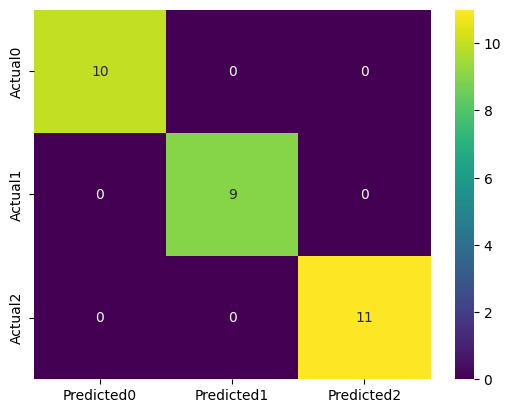

In [91]:
plot2(y_test,y_pred)

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

